In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim, DataBC, Bing
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint
import shapely
import shapely.speedups
import os
import pointpats.quadrat_statistics as qs
from pointpats import PointPattern, PoissonPointProcess
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import contextily as ctx
from scipy.spatial import cKDTree  
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats
from sklearn.datasets.samples_generator import make_blobs, make_circles
from mpl_toolkits import mplot3d
import math
import seaborn as sns
from pysal.viz.splot.esda import lisa_cluster
import pysal as ps

plt.rcParams["font.family"] = "Times New Roman"
pd.options.display.max_columns = 50
shapely.speedups.enable()
%matplotlib inline

/Users/GeorgePyne/anaconda3/envs/spatiotemporal/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
def add_basemap(ax, zoom,xmin, xmax, ymin, ymax, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    """Function to add base map to geopandas plot axis 
    Adapted from: http://geopandas.org/gallery/plotting_basemap_background.html"""
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [155]:
plt.rcParams["figure.figsize"] = [10.0,10.0]

# 1. Introduction

# 2. Literature Review

# 3. Data

## 3.1 Explaination

In [10]:
residential = ['100001','100002','100003']
commericial = ['104007', '104008', '112001', '113001']

## 3.2 Exploration

In [286]:
vehicle_ped_counts = pd.read_excel("DataDownload/8hrVeh&PedVolume_6-Mar-2018.xlsx")
coords = []
for lon, lat in zip(vehicle_ped_counts.Longitude, vehicle_ped_counts.Latitude):
    try:
        coords.append(Point(lon, lat))
    except TypeError:
        print("Invalid lon({0}) or lat({1})".format(lon, lat))
vehicle_ped_counts['geometry'] = pd.Series(coords)
vehicle_ped_counts = gpd.GeoDataFrame(vehicle_ped_counts)
vehicle_ped_counts.crs = {'init': 'epsg:4326'}
vehicle_ped_counts = vehicle_ped_counts[vehicle_ped_counts['Longitude']< -78]
vehicle_ped_counts = vehicle_ped_counts.cx[xmin:xmax, ymin:ymax]

In [308]:
veh = vehicle_ped_counts.groupby(['Main']).agg({'8 Peak Hr Vehicle Volume': 'mean'}).reset_index()
ped = vehicle_ped_counts.groupby(['Main']).agg({'8 Peak Hr Pedestrian Volume': 'mean'}).reset_index()
veh.columns = ['Main road', 'Average peak vehicle volume']
ped.columns = ['Main road', 'Average peak pedestrian volume']

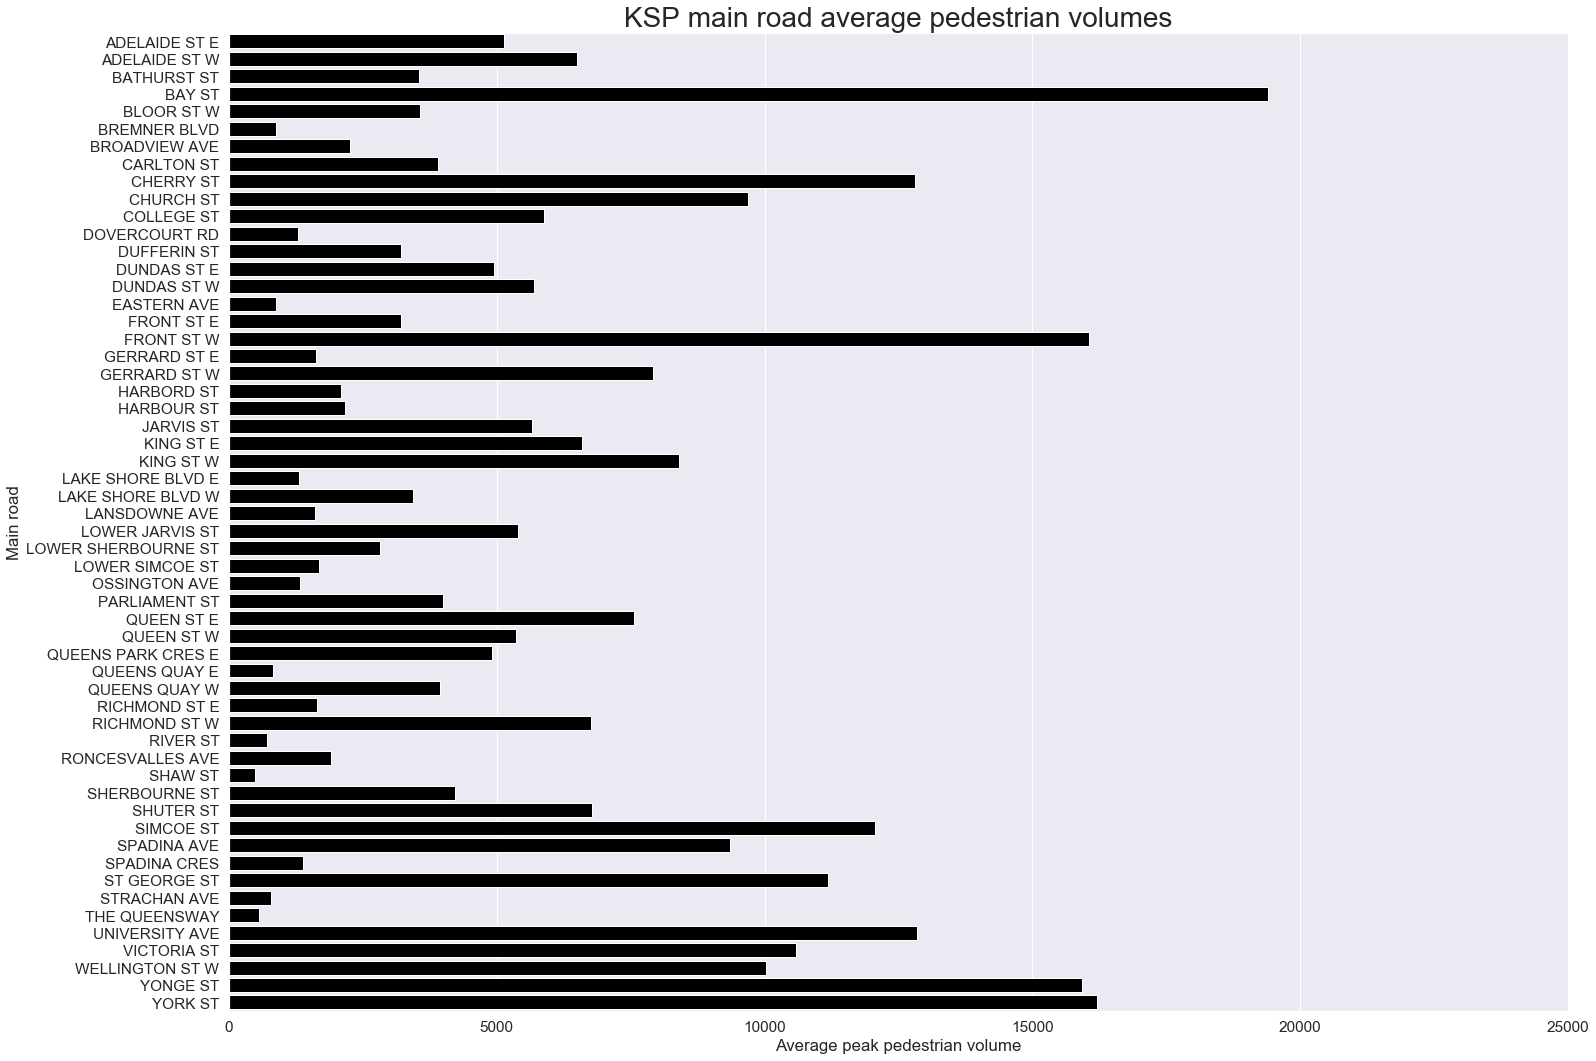

In [317]:
f,ax = plt.subplots(1, figsize=(24.0, 18.0))
sns.barplot(x="Average peak pedestrian volume", y="Main road", data=ped,
            label="Side 1 Route", color="black", ax=ax);
ax.set_xlim(0,25000)
ax.set_title('KSP main road average pedestrian volumes', size=28);

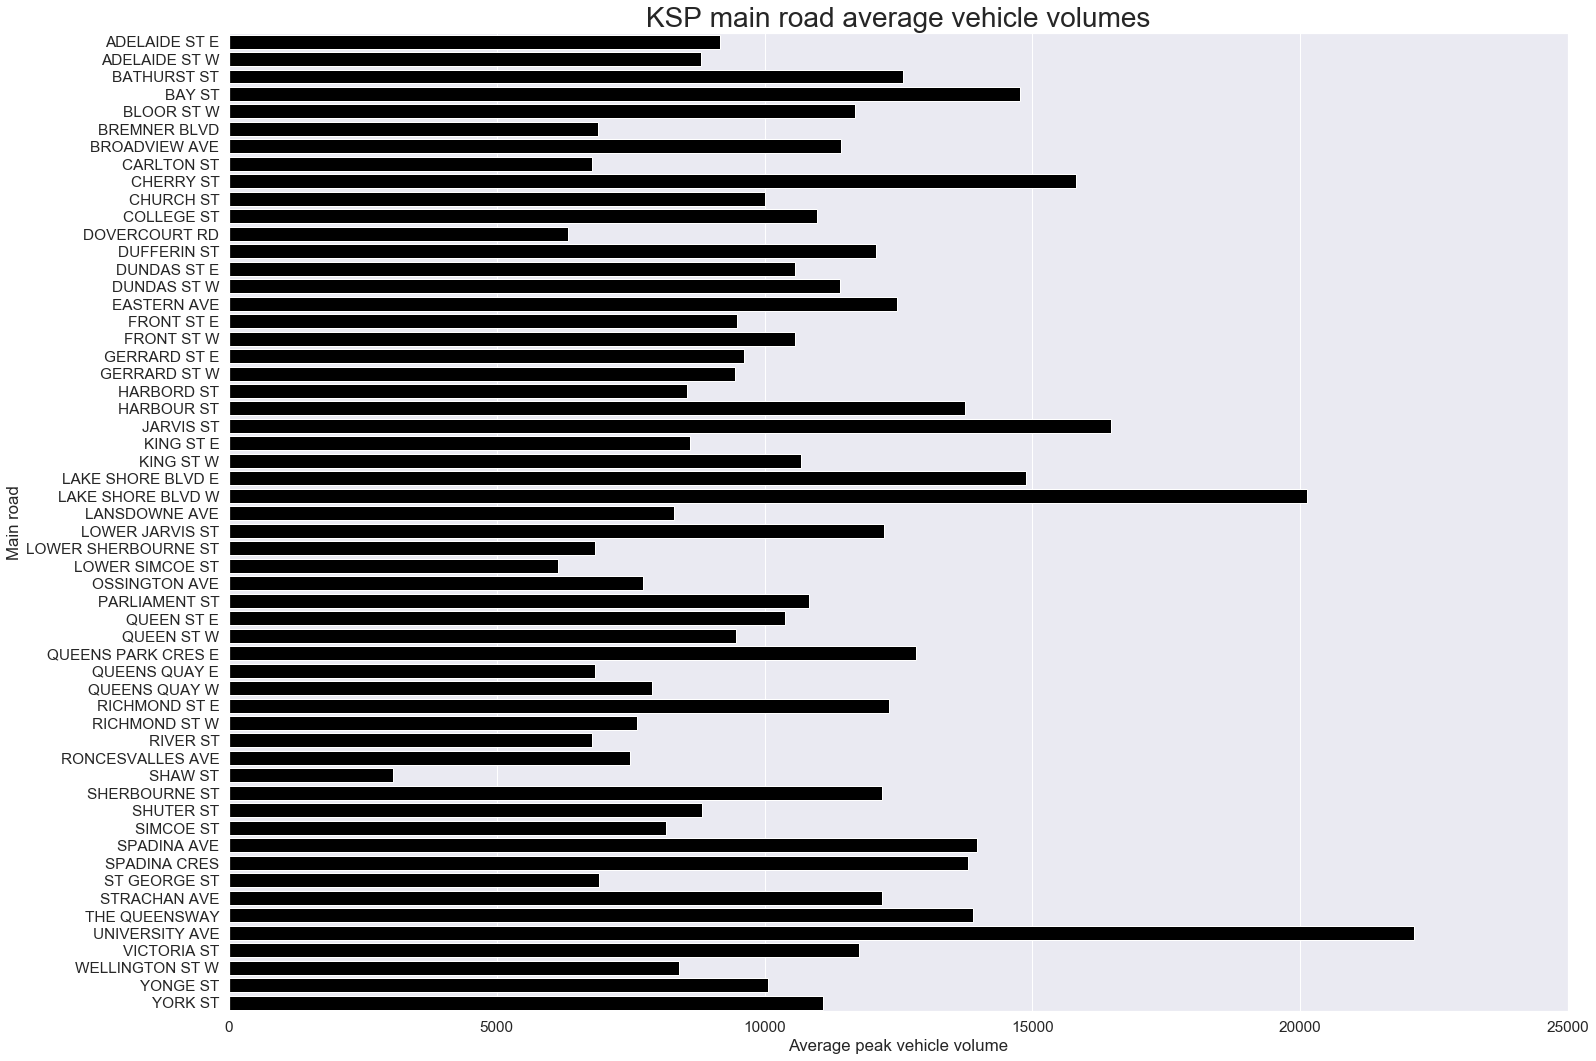

In [318]:
f,ax = plt.subplots(1, figsize=(24.0, 18.0))
sns.barplot(x="Average peak vehicle volume", y="Main road", data=veh,
            label="Side 1 Route", color="black", ax=ax);
ax.set_xlim(0,25000)
ax.set_title('KSP main road average vehicle volumes', size=28);

For visualisation purporses pedestrian and vehicle counts were averaged to the ___ main routes in the KSP area, however this dataset contains these values for over ___ individual routes which can then be used to help classify buildings in close proximity to these routes.

In [320]:
# Bounds taken from ksp_br.total_bounds
xmin, ymin, xmax, ymax = [-79.45184606,  43.63641291, -79.34889483,  43.66428591]

In [205]:
ksp_br = gpd.read_file("Data_EDA/property_bnds_gcc_wgs84/KSP_STREETS.shp")
ksp_br.crs = {'init': 'epsg:4326'}
xmin, ymin, xmax, ymax = ksp_br.total_bounds

In [6]:
com_buildings = gpd.read_file("Data_EDA/property_bnds_gcc_wgs84/commercial_buildings.shp").cx[xmin:xmax, ymin:ymax]

In [7]:
res_buildings = gpd.read_file("Data_EDA/property_bnds_gcc_wgs84/residential_buildings.shp").cx[xmin:xmax, ymin:ymax]

In [8]:
shp = gpd.GeoDataFrame( pd.concat([res_buildings, com_buildings], ignore_index=True))
shp.crs = {'init': 'epsg:4326'}

In [11]:
shp['CLASS'] = shp['FCODE'].apply(lambda x: str(x) in residential)
shp['CLASS'] = shp['CLASS'].replace(True, 'Residential').replace(False, 'Commercial')

In [353]:
ksp = pd.read_csv("DataDownload/ksp_travel_times_2017.csv")

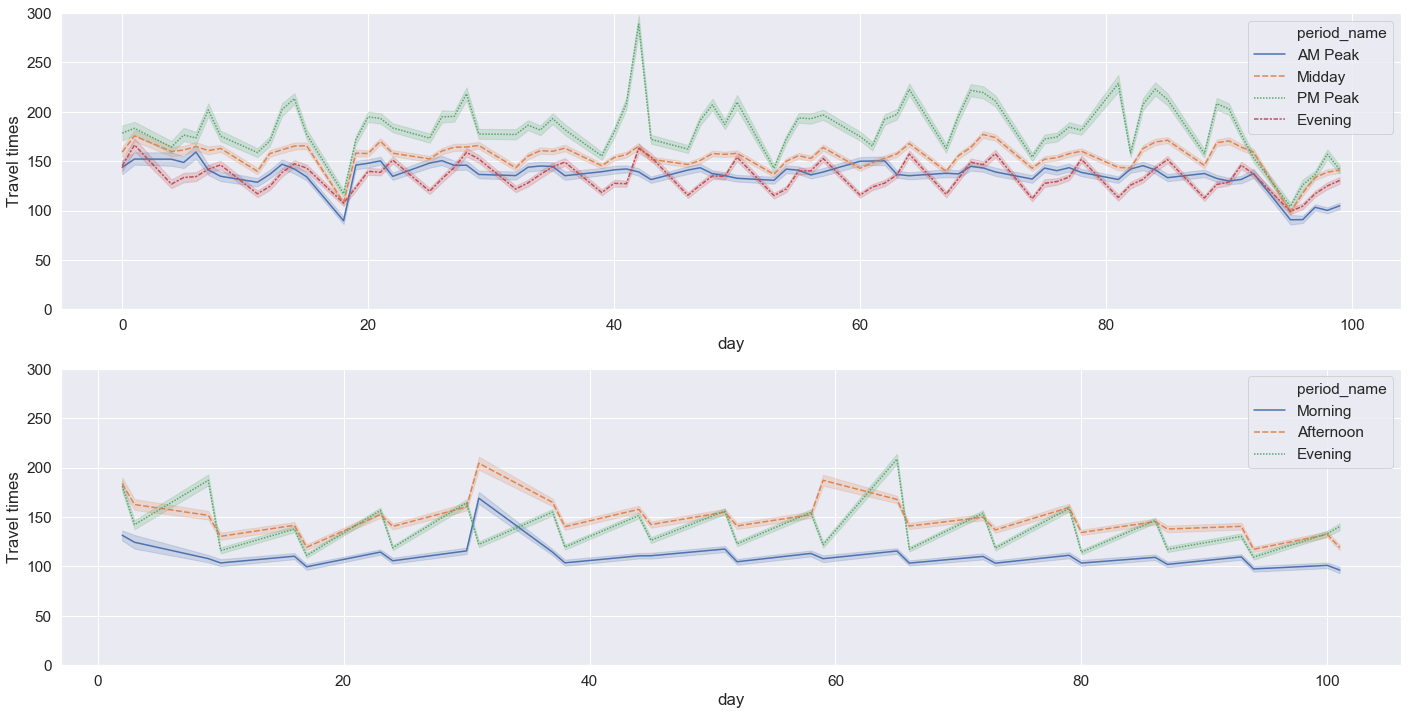

In [365]:
f, axes = plt.subplots(2, figsize=(24.0, 12.0))
tsg_wd = tsg.loc[tsg.day_type == 'Weekday']
tsg_we = tsg.loc[tsg.day_type == 'Weekend']
ax1 = sns.lineplot(x="day", y="tt",
             style="period_name", 
             data=tsg_wd,hue="period_name", ax=axes[0]);
ax2 = sns.lineplot(x="day", y="tt",
             style="period_name", 
             data=tsg_we,hue="period_name", ax=axes[1]);
ax1.set_ylim(0,300);
ax2.set_ylim(0,300);
ax1.set_ylabel('Travel times')
ax2.set_ylabel('Travel times');

In [105]:
br = gpd.read_file("DataDownload/Bluetooth Routes.geojson")

In [106]:
ksp_test = ksp.groupby(['result_id']).agg({'tt':'mean'}).reset_index()
ksp_br = br.merge(ksp_test.rename(columns={"result_id":'RESULTID'}), on='RESULTID')

In [107]:
ksp.datetime_bin = pd.to_datetime(ksp['datetime_bin'])

In [108]:
ksp_tt = ksp.groupby(['result_id', 'period_name', 'day_type']).agg({'tt':'mean'}).reset_index()

In [109]:

def ckdnearest(gdA, gdB, bcol):   
    """Function creating a kd-tree for quick nearest-neighbor lookup
    Adpated from gene:
    https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe"""
    
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    df = pd.DataFrame.from_dict({'distance_from_'+str(bcol): dist.astype(float),
                             bcol : gdB.loc[idx, bcol].values})
    return df

In [110]:
apart = pd.read_csv("Data_EDA/apartments_geocoded.csv")

coords=[]
for lon, lat in zip(apart.Longitude, apart.Latitude):
    try:
        coords.append(Point(lon,lat))
    except:
        coords.append(None)
apart['geometry'] = pd.Series(coords)

    
    

In [111]:
br_test = br.copy()

In [112]:
road_id,points = [],[]

for ID, geom in zip(br_test.RESULTID, br_test.geometry):
    if isinstance(geom,shapely.geometry.multilinestring.MultiLineString):
        for line in list(geom):
            try:
                for coord in list(line.coords):
                    road_id.append(ID)
                    points.append(Point(coord))
            except:
                continue
    elif isinstance(geom, shapely.geometry.linestring.LineString):
        try:
            for coord in list(geom.coords):
                road_id.append(ID)
                points.append(Point(coord))
        except:
            continue
    

In [239]:
clip = gpd.GeoDataFrame( pd.concat([res_buildings, com_buildings], ignore_index=True))
clip['CLASS'] = clip['FCODE'].apply(lambda x: str(x) in residential)
clip['CLASS'] = clip['CLASS'].replace(True, 'Residential').replace(False, 'Commercial')
clip.crs = {'init': 'epsg:4326'}
clip['centroids'] = clip.geometry.apply(lambda x: x.centroid)
clip.geometry = clip.geometry.apply(lambda x: x.convex_hull if isinstance(x, shapely.geometry.MultiPolygon) else x)
clip[['OBJECTID_l','CLASS','geometry']].cx[xmin:xmax, ymin:ymax].to_file('DSSS_data/building_polys.geojson', 
                                                                         driver='GeoJSON')         
# clip = clip.to_crs(epsg=3857)
# ax = clip.plot(column='CLASS', legend=True, cmap='bwr');
# ax.set_axis_off()
# xmin, ymin, xmax, ymax = clip.total_bounds
# add_basemap(ax, 13,xmin, ymin, xmax, ymax, url=ctx.sources.ST_TONER_LITE)

In [24]:
building_centroids = gpd.GeoDataFrame(clip[['OBJECTID_l','centroids','CLASS']].rename(columns={'centroids':'geometry'}))
building_centroids.crs = {'init': 'epsg:4326'}
# building_centroids = building_centroids.to_crs(epsg=4326)

In [148]:
station_data = pd.read_csv("Data_EDA/TTC_SubwayStns_20120119/station_locations.csv")\
.rename(columns={'Station':'STATION'})
station_locations = gpd.read_file("/Users/GeorgePyne/Documents/CASA/DSSS/Assessment/Data_EDA/TTC_SubwayStns_20120119/subwayStations.shp")
station_locations = station_locations.to_crs(epsg=4326)
station_locations = station_locations.cx[xmin:xmax, ymin:ymax]
station_locations.STATION = station_locations.STATION.str.upper()
station = station_locations.merge(station_data, on='STATION')
station_data, station_locations = None , None

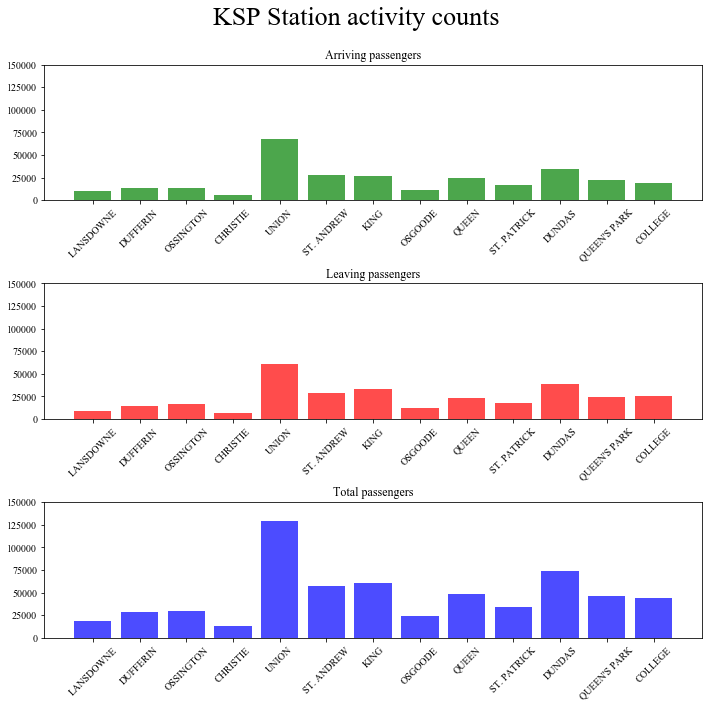

In [156]:
ksp_stations = station.cx[xmin:xmax, ymin:ymax]
ksp_stations.To, ksp_stations.From, ksp_stations.Total = ksp_stations.To.str.replace(',',''), ksp_stations.From.str.replace(',',''), ksp_stations.Total.str.replace(',','')
ksp_stations.To, ksp_stations.From, ksp_stations.Total = ksp_stations.To.astype(int), ksp_stations.From.astype(int), ksp_stations.Total.astype(int)

y_lim = 150000
fig, axs = plt.subplots(3)
fig.suptitle('KSP Station activity counts',size=26, verticalalignment='top')
objects = tuple(ksp_stations.STATION.to_list())
labels = ksp_stations.STATION.to_list()
y_pos = np.arange(len(objects))
inflows = ksp_stations.To.to_list()
outflows = ksp_stations.From.to_list()
total = ksp_stations.Total.to_list()
ax1 = axs[0].bar(y_pos, inflows, align='center',tick_label=labels,alpha=0.7,color='green')
ax2 = axs[1].bar(y_pos, outflows, align='center',tick_label=labels,alpha=0.7,color='red')
ax3 = axs[2].bar(y_pos, total, align='center',tick_label=labels,alpha=0.7,color='blue')

fig.axes[0].set_ylim(0, y_lim);
fig.axes[1].set_ylim(0, y_lim);
fig.axes[2].set_ylim(0, y_lim);

for fig in axs:
    for tick in fig.get_xticklabels():
        tick.set_rotation(45)

axs[0].set_title('Arriving passengers')
axs[1].set_title('Leaving passengers')
axs[2].set_title('Total passengers')

plt.tight_layout(w_pad=2)
plt.subplots_adjust(top=0.90)

In [27]:
vehicle_ped_counts = vehicle_ped_counts.cx[xmin:xmax, ymin:ymax]

The kd-tree search function require point geometries for NN search, however the pedestrian volume, vehicle volume and travel-times are recorded in relation to the KSP road network (linestrings). In order to incorporate this data into the NN search for buildings in the KSP study area, the following geometric operation was carried out to decompose the Bluetooth Route into point classes based on their linestrings vertices. This enabled the merging and NN operations to be carried out for the final training dataset. This was achieved by the following:
```python

road_id,points = [],[]
for ID, geom in zip(ksp_br.RESULTID, ksp_br.geometry):
    if isinstance(geom,shapely.geometry.multilinestring.MultiLineString):
        for line in list(geom):
            try:
                for coord in list(line.coords):
                    road_id.append(ID)
                    points.append(Point(coord))
            except:
                continue
    elif isinstance(geom, shapely.geometry.linestring.LineString):
        try:
            for coord in list(geom.coords):
                road_id.append(ID)
                points.append(Point(coord))
        except:
            continue

road_points = gpd.GeoDataFrame(pd.DataFrame({"RESULTID":road_id, "geometry":points})) # create new Point gdf
road_points.to_crs = {'init': 'epsg:4326'} # set crs
```

In [28]:
road_id,points = [],[]
for ID, geom in zip(ksp_br.RESULTID, ksp_br.geometry):
    if isinstance(geom,shapely.geometry.multilinestring.MultiLineString):
        for line in list(geom):
            try:
                for coord in list(line.coords):
                    road_id.append(ID)
                    points.append(Point(coord))
            except:
                continue
    elif isinstance(geom, shapely.geometry.linestring.LineString):
        try:
            for coord in list(geom.coords):
                road_id.append(ID)
                points.append(Point(coord))
        except:
            continue

In [ ]:
road_points = gpd.GeoDataFrame(pd.DataFrame({"RESULTID":road_id, "geometry":points}))
road_points.to_crs = {'init': 'epsg:4326'}
road_points.head(3)

In [81]:
ksp['datetime_bin'] = pd.DatetimeIndex(ksp['datetime_bin'])
kap_test = ksp
kap_test.index = kap_test['datetime_bin']
kap_test = kap_test.groupby([pd.TimeGrouper('1H'), 'result_id', 'period_name']).agg({'tt':'mean'})
kap_test = kap_test.reset_index()
kap_test['DateTimeDup'] = kap_test.datetime_bin.duplicated()
kap_test = kap_test.loc[kap_test['DateTimeDup']==True]
tt = kap_test.groupby(['result_id','period_name'])['tt'].mean().unstack().reset_index()#.rename_axis(None).rename_axis(None, 1)

/Users/GeorgePyne/anaconda3/envs/spatiotemporal/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  after removing the cwd from sys.path.


In [82]:
tt.head(3)

period_name,result_id,AM Peak,Afternoon,Evening,Midday,Morning,Overnight,PM Peak
0,AD_PA_EA_BV,151.065397,145.743213,144.728492,157.186062,144.720052,126.756410,145.071646
1,AD_SP_AD_UN,300.982712,266.682705,251.433821,284.550902,152.536085,165.500349,412.099203
2,AD_UN_AD_YO,116.736033,101.614834,139.445313,182.793927,90.458763,93.889036,306.421026


In [83]:
vehicle_ped_counts['Sensor'] = 'Sensor ' + vehicle_ped_counts['TCS #'].astype(str)
vehicle_ped_counts = vehicle_ped_counts.reset_index().drop(columns='index',axis=1)

In [84]:
vehicle_ped_counts.head(3)

,TCS #,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,geometry,Sensor
0,2,JARVIS ST,NaN,FRONT ST E,NaN,11/15/1948,43.649418,-79.371446,2017-06-21,15662,13535,POINT (-79.37144600000001 43.649418),Sensor 2
1,3,KING ST E,NaN,JARVIS ST,NaN,08/23/1950,43.650461,-79.371924,2016-09-17,12960,7333,POINT (-79.3719239 43.6504606),Sensor 3
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,09/12/1958,43.651534,-79.372360,2016-11-08,17770,7083,POINT (-79.37236 43.6515337),Sensor 4


In [85]:
road_points.head(3)

,RESULTID,geometry
0,DU_BA_CO_BA,POINT (-79.40602236410948 43.65231168705245)
1,DU_BA_CO_BA,POINT (-79.40683566166271 43.65428715128314)
2,DU_BA_CO_BA,POINT (-79.40753886101146 43.65602654961585)


In [35]:
building_centroids.head(3)

,OBJECTID_l,geometry,CLASS
0,326352.0,POINT (-79.59123533489179 43.75889450756516),Residential
1,456712.0,POINT (-79.5916552254438 43.75895762179936),Residential
2,326353.0,POINT (-79.59210380417133 43.7589551328141),Residential


In [123]:
road_points = road_points.merge(tt.rename(columns={'result_id':'RESULTID'}), on='RESULTID')

In [86]:
if not os.path.exists('DSSS_data'):
    os.makedirs('DSSS_data')
    nps[['8 Peak Hr Vehicle Volume', '8 Peak Hr Pedestrian Volume','To', 'From',
       'Total', 'AM Peak', 'Afternoon', 'Evening', 'Midday', 'Morning',
       'Overnight', 'PM Peak', 'distance_from_STATION','CLASS']].to_csv('DSSS_data/model_data.csv',index=False)

In [44]:
nps = pd.read_csv('DSSS_data/model_data_predictions.csv')

In [41]:
ksp_br.head(3)

,_id,OBJECTID,RESULTID,START_STREET,DIRECTION,START_CROSS_STREET,END_STREET,END_CROSS_STREET,START_DATE,END_DATE,LENGTH,Shape__Length,geometry,tt
0,16,12,DU_BA_CO_BA,Bathurst,NB,Dundas,Bathurst,College,2017-10-05T04:00:00,2018-10-10T04:00:00,510,668.979447,(LINESTRING (-79.40602236410948 43.65231168705...,86.548853
1,17,13,CO_PA_DU_PA,Parliament,SB,College,Parliament,Dundas,2017-09-17T04:00:00,2018-10-10T04:00:00,586,776.970343,(LINESTRING (-79.36798185079718 43.66428590621...,113.012358
2,33,29,FB_SP_FR_SP,Spadina,NB,Bremner,Spadina,Front,2017-09-27T04:00:00,None,291,350.212947,(LINESTRING (-79.3930046074104 43.640562821799...,52.472770


In [89]:
ksp['datetime_bin'] = pd.DatetimeIndex(ksp['datetime_bin'])

In [90]:
ksp['datetime_bin'] = pd.DatetimeIndex(ksp['datetime_bin'])
kap_test = ksp
kap_test.index = kap_test['datetime_bin']
kap_test = kap_test.groupby([pd.TimeGrouper('1H'), 'result_id', 'period_name']).agg({'tt':'mean'})
kap_test = kap_test.reset_index()
kap_test['DateTimeDup'] = kap_test.datetime_bin.duplicated()
kap_test = kap_test.loc[kap_test['DateTimeDup']==True]
tt = kap_test.groupby(['result_id','period_name'])['tt'].mean().unstack().reset_index()#.rename_axis(None).rename_axis(None, 1)

/Users/GeorgePyne/anaconda3/envs/spatiotemporal/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  after removing the cwd from sys.path.


In [91]:
kap_test['DateTimeDup'] = kap_test.datetime_bin.duplicated()
kap_test = kap_test.loc[kap_test['DateTimeDup']==True]

In [92]:
tt = kap_test.groupby(['result_id','period_name'])['tt'].mean().unstack().reset_index()#.rename_axis(None).rename_axis(None, 1)

In [95]:
ksp_base = ksp.datetime_bin.dt.normalize().head(1)['2017-09-21 00:15:00 ']

In [96]:
ksp['day'] = ksp.datetime_bin.dt.normalize() - ksp_base

In [97]:
ksp_base = ksp.datetime_bin.dt.normalize().head(1)['2017-09-21 00:15:00 ']
ksp['day'] = ksp.datetime_bin.dt.normalize() - ksp_base
tsg = ksp.drop('datetime_bin',axis=1).reset_index()
timestamp = tsg.day[0]
tsg.day = (tsg.day.astype(int)/86400000000000).astype(int)
tsg = tsg.loc[tsg.period_name.isin(tsg.period_name.unique()[1:])]

In [98]:
timestamp = tsg.day[0]
tsg.day = (tsg.day.astype(int)/86400000000000).astype(int)
tsg = tsg.loc[tsg.period_name.isin(tsg.period_name.unique()[1:])]

In [99]:
tsg.day = (tsg.day.astype(int)/86400000000000).astype(int)
tsg = tsg.loc[tsg.period_name.isin(tsg.period_name.unique()[1:])]

In [100]:
tsg = tsg.loc[tsg.period_name.isin(tsg.period_name.unique()[1:])]

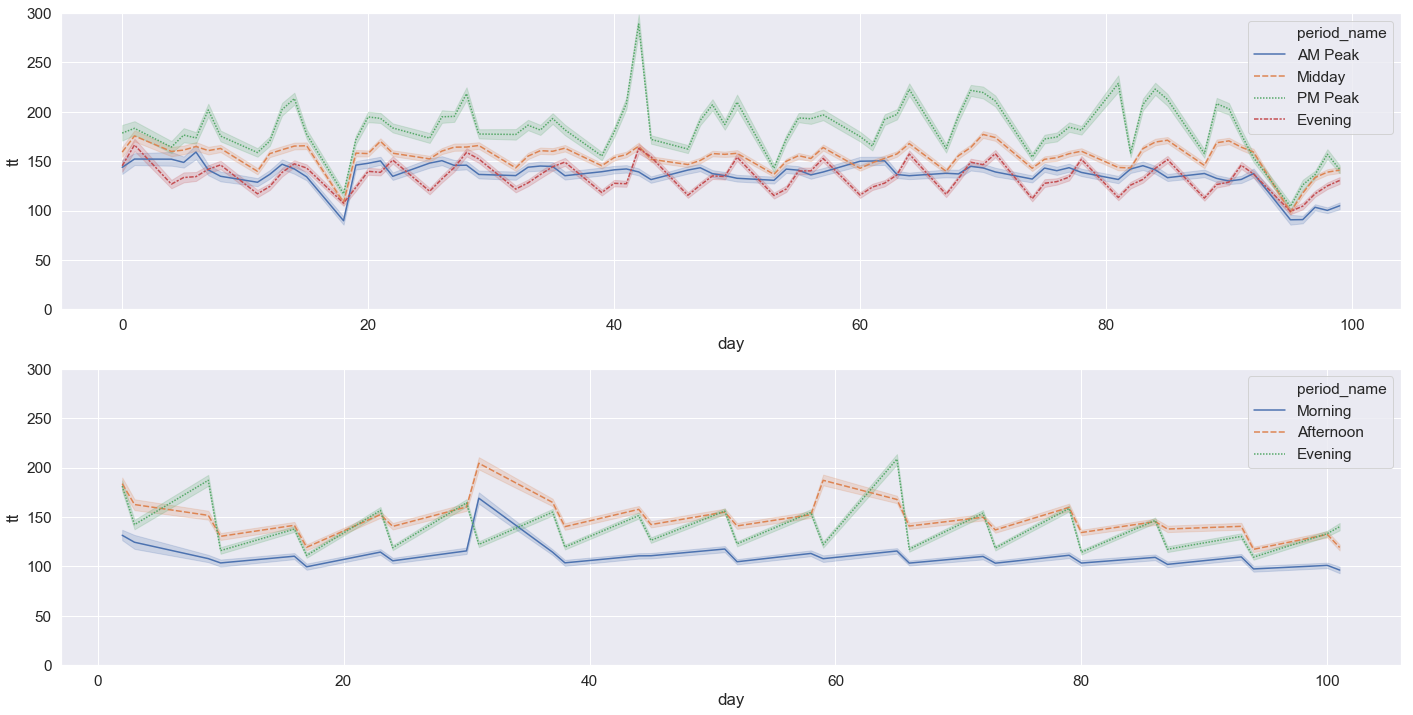

In [323]:
f, axes = plt.subplots(2, figsize=(24.0, 12.0))
tsg_wd = tsg.loc[tsg.day_type == 'Weekday']
tsg_we = tsg.loc[tsg.day_type == 'Weekend']
ax1 = sns.lineplot(x="day", y="tt",
             style="period_name", 
             data=tsg_wd,hue="period_name", ax=axes[0]);
ax2 = sns.lineplot(x="day", y="tt",
             style="period_name", 
             data=tsg_we,hue="period_name", ax=axes[1]);
ax1.set_ylim(0,300);
ax2.set_ylim(0,300);

In [94]:
def roundup(x):
    return int(math.ceil(x / 500.0)) * 500

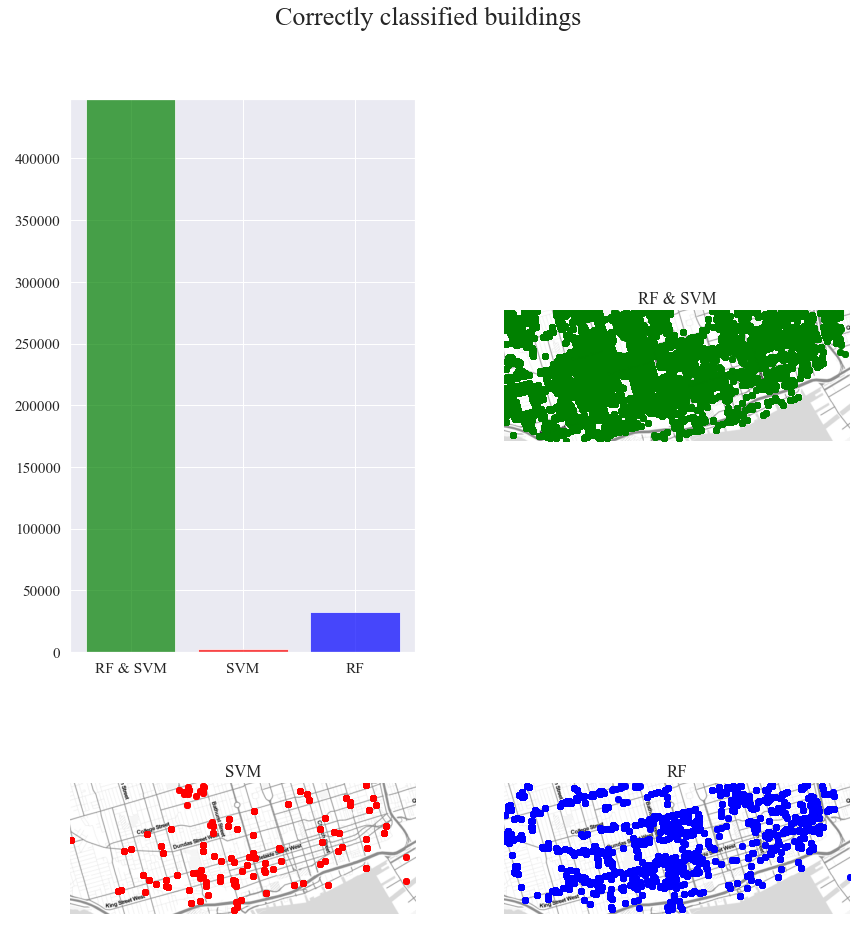

In [288]:

both = final_data_shp[(final_data_shp['RF_score'] == 1) &  (final_data_shp['SVM_score'] == 1)]
svms = final_data_shp[(final_data_shp['RF_score'] == 0) &  (final_data_shp['SVM_score'] == 1)]
rfs = final_data_shp[(final_data_shp['RF_score'] == 1) &  (final_data_shp['SVM_score'] == 0)]

length_max = max([len(i) for i in [both,rfs,svms]])
y_lim = roundup(length_max)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.0, 16.0))

# Bar Graph
objects = ('RF & SVM', 'SVM', 'RF')
labels = ['RF & SVM', 'SVM', 'RF']
y_pos = np.arange(len(objects))
performance = [len(i) for i in [both,svms,rfs]]
ax1 = ax1.bar(y_pos, performance, align='center',color=['green','red','blue'],tick_label=labels,alpha=0.7)
fig.axes[0].set_ylim(0, y_lim)


xmin, ymin, xmax, ymax = final_data_shp.to_crs(epsg=3857).total_bounds


wm = both.to_crs(epsg=3857)
ax2 = wm.plot(color='green', ax=ax2, alpha=0.7)
add_basemap(ax=ax2,zoom=13,xmin=xmin,ymin=ymin,xmax=xmax,ymax=ymax,url=ctx.sources.ST_TONER_LITE)
ax2.set_title(labels[0])
ax2.set_axis_off()

wm = svms.to_crs(epsg=3857)
ax3 = wm.plot(color='red', ax=ax3, alpha=0.7)
add_basemap(ax=ax3,zoom=13,xmin=xmin,ymin=ymin,xmax=xmax,ymax=ymax,url=ctx.sources.ST_TONER_LITE)
ax3.set_title(labels[1])
ax3.set_axis_off()

wm = rfs.to_crs(epsg=3857)
ax4 = wm.plot(color='blue', ax=ax4, alpha=0.7)
add_basemap(ax=ax4,zoom=13,xmin=xmin,ymin=ymin,xmax=xmax,ymax=ymax,url=ctx.sources.ST_TONER_LITE)
ax4.set_title(labels[2])
ax4.set_axis_off()

plt.tight_layout(w_pad=2)
plt.subplots_adjust(top=0.90)
fig.suptitle('Correctly classified buildings', size=26, verticalalignment='top');


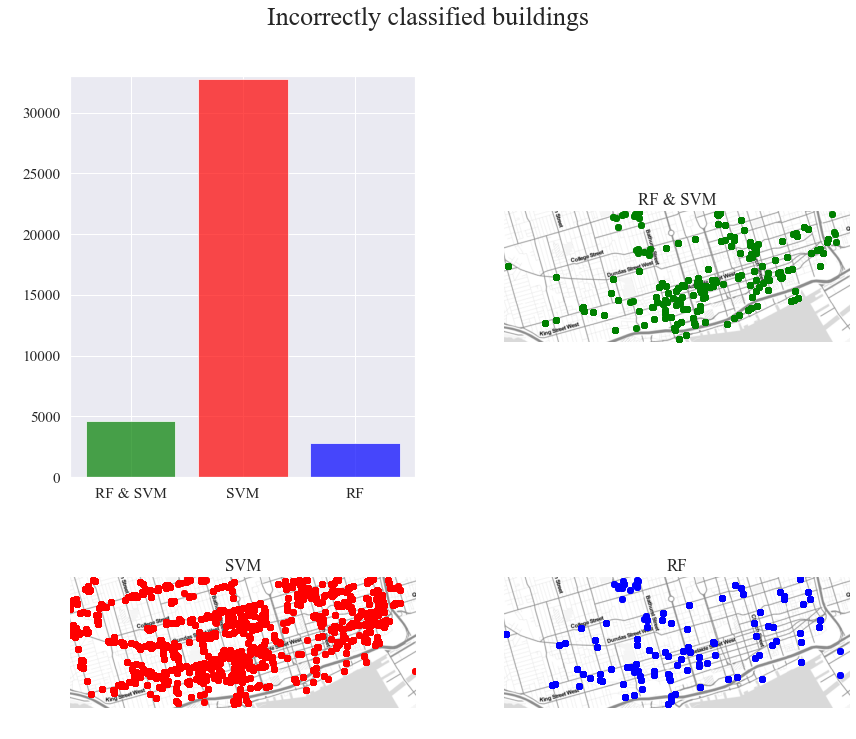

In [289]:
both = final_data_shp[(final_data_shp['RF_score'] == 0) &  (final_data_shp['SVM_score'] == 0)]
svms = final_data_shp[(final_data_shp['RF_score'] == 1) &  (final_data_shp['SVM_score'] == 0)]
rfs = final_data_shp[(final_data_shp['RF_score'] == 0) &  (final_data_shp['SVM_score'] == 1)]

length_max = max([len(i) for i in [both,rfs,svms]])
y_lim = roundup(length_max)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.0, 12.0))

# Bar Graph
objects = ('RF & SVM', 'SVM', 'RF')
labels = ['RF & SVM', 'SVM', 'RF']
y_pos = np.arange(len(objects))
performance = [len(i) for i in [both,svms,rfs]]
ax1 = ax1.bar(y_pos, performance, align='center',color=['green','red','blue'],tick_label=labels,alpha=0.7)
fig.axes[0].set_ylim(0, y_lim)


xmin, ymin, xmax, ymax = final_data_shp.to_crs(epsg=3857).total_bounds


wm = both.to_crs(epsg=3857)
ax2 = wm.plot(color='green', ax=ax2, alpha=0.7)
add_basemap(ax=ax2,zoom=13,xmin=xmin,ymin=ymin,xmax=xmax,ymax=ymax,url=ctx.sources.ST_TONER_LITE)
ax2.set_title(labels[0])
ax2.set_axis_off()

wm = svms.to_crs(epsg=3857)
ax3 = wm.plot(color='red', ax=ax3, alpha=0.7)
add_basemap(ax=ax3,zoom=13,xmin=xmin,ymin=ymin,xmax=xmax,ymax=ymax,url=ctx.sources.ST_TONER_LITE)
ax3.set_title(labels[1])
ax3.set_axis_off()

wm = rfs.to_crs(epsg=3857)
ax4 = wm.plot(color='blue', ax=ax4, alpha=0.7)
add_basemap(ax=ax4,zoom=13,xmin=xmin,ymin=ymin,xmax=xmax,ymax=ymax,url=ctx.sources.ST_TONER_LITE)
ax4.set_title(labels[2])
ax4.set_axis_off()

plt.tight_layout(w_pad=2)
plt.subplots_adjust(top=0.90)
fig.suptitle('Incorrectly classified buildings', size=26, verticalalignment='top');

In [302]:
shp['BT'] = shp.FCODE.replace(adress_keys)

In [305]:
res_buildings = shp.loc[shp['FCODE'].astype(str).isin(residential)]
com_buildings = shp.loc[shp['FCODE'].astype(str).isin(commericial)]

In [307]:
res_buildings['BT'],com_buildings['BT'] = [1 for i in res_buildings['BT']],[0 for i in com_buildings['BT']]

/Users/GeorgePyne/anaconda3/envs/spatiotemporal/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
xmin, ymin, xmax, ymax = final_data_shp.total_bounds
ksp_bt = gpd.GeoDataFrame(pd.concat([res_buildings,com_buildings])).cx[xmin:xmax, ymin:ymax]

NameError: name 'final_data_shp' is not defined

In [323]:
w = ps.lib.weights.contiguity.Queen.from_dataframe(ksp_bt)
w.transform = 'r'

/Users/GeorgePyne/anaconda3/envs/spatiotemporal/lib/python3.7/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 507 disconnected observations 
  Island ids: 129, 176, 177, 257, 283, 362, 557, 696, 808, 818, 844, 847, 936, 1052, 1056, 1503, 1551, 1592, 1899, 1901, 2077, 2082, 2143, 2174, 2225, 2297, 2404, 2456, 2490, 2494, 2571, 2645, 2817, 2880, 2944, 3206, 3211, 3286, 3290, 3337, 3353, 3360, 3456, 3475, 3494, 3610, 3639, 3652, 3735, 3803, 3832, 3907, 3949, 4226, 4259, 4551, 4700, 4745, 4779, 4862, 4928, 5023, 5070, 5086, 5096, 5106, 5111, 5351, 5538, 5846, 5934, 6099, 6355, 6356, 6591, 6655, 6766, 6806, 6927, 6942, 6950, 7064, 7092, 7135, 7143, 7148, 7191, 7240, 7322, 7533, 7539, 7661, 7680, 7718, 7731, 7740, 7744, 7843, 7854, 8098, 8115, 8119, 8136, 8152, 8189, 8243, 8253, 8479, 8584, 8694, 8797, 8871, 8891, 8925, 8958, 9040, 9049, 9054, 9101, 9155, 9427, 9469, 9476, 9483, 9495, 9531, 9538, 9544, 9545, 9681, 9718, 9725, 9922, 9940, 9993, 10079, 10082, 10089, 1012

('WARNING: ', 129, ' is an island (no neighbors)')
('WARNING: ', 176, ' is an island (no neighbors)')
('WARNING: ', 177, ' is an island (no neighbors)')
('WARNING: ', 257, ' is an island (no neighbors)')
('WARNING: ', 283, ' is an island (no neighbors)')
('WARNING: ', 362, ' is an island (no neighbors)')
('WARNING: ', 557, ' is an island (no neighbors)')
('WARNING: ', 696, ' is an island (no neighbors)')
('WARNING: ', 808, ' is an island (no neighbors)')
('WARNING: ', 818, ' is an island (no neighbors)')
('WARNING: ', 844, ' is an island (no neighbors)')
('WARNING: ', 847, ' is an island (no neighbors)')
('WARNING: ', 936, ' is an island (no neighbors)')
('WARNING: ', 1052, ' is an island (no neighbors)')
('WARNING: ', 1056, ' is an island (no neighbors)')
('WARNING: ', 1503, ' is an island (no neighbors)')
('WARNING: ', 1551, ' is an island (no neighbors)')
('WARNING: ', 1592, ' is an island (no neighbors)')
('WARNING: ', 1899, ' is an island (no neighbors)')
('WARNING: ', 1901, ' is 

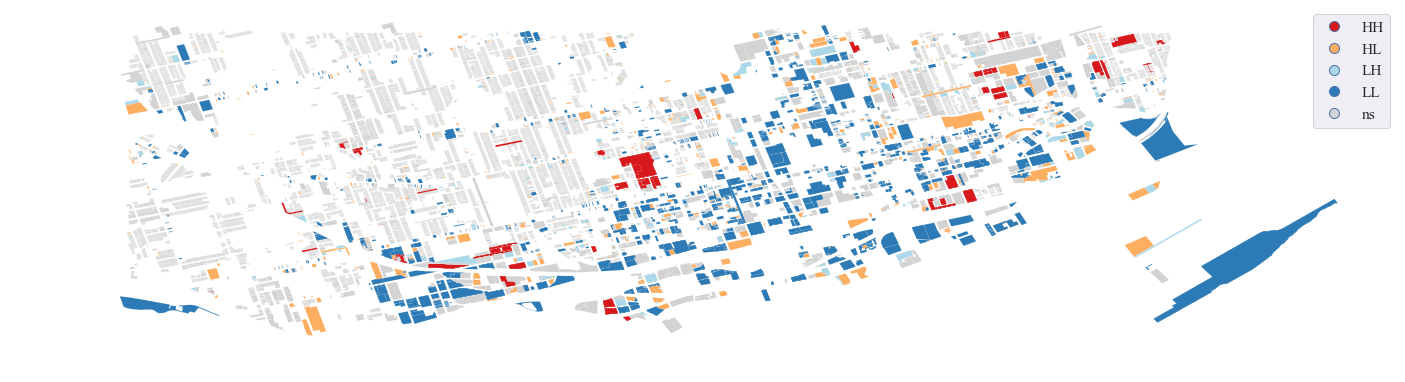

In [327]:
y = ksp_bt['BT'].values

w = ps.lib.weights.contiguity.Queen.from_dataframe(ksp_bt)
w.transform = 'r'
moran = ps.explore.esda.moran.Moran_Local(y, w)
lisa_cluster(moran, ksp_bt);

In [349]:
apart = pd.read_csv("Data_EDA/apartments_geocoded.csv")
apart[apart.columns[0:-2]].sample(5)

,_id,AIR_CONDITIONING_TYPE,AMENITIES_AVAILABLE,BALCONIES,BARRIER_FREE_ACCESSIBILTY_ENTR,BIKE_PARKING,EXTERIOR_FIRE_ESCAPE,FACILITIES_AVAILABLE?,FIRE_ALARM,GARBAGE_CHUTES,HEATING_TYPE,INTERCOM,IS_THERE_A_COOLING_ROOM?,IS_THERE_EMERGENCY_POWER?,LAUNDRY_ROOM,LOCKER_OR_STORAGE_ROOM,NO_BARRIERFREE_ACCESSBLE_UNITS,NO_OF_ACCESSIBLEPARKING_SPACES,NO_OF_ELEVATORS,NO_OF_STOREYS,NO_OF_UNITS,NON-SMOKING_BUILDING,PARKING_TYPE,PETS_ALLOWED,PROP_MANAGEMENT_COMPANY_NAME,PROPERTY_TYPE,RSN,SEPARATE_GAS_METERS_EACH_UNIT,SEPARATE_HYDRO_METER_EACH_UNIT,SEPARATE_WATER_METERS_EA_UNIT,SITE_ADDRESS,SPRINKLER_SYSTEM,VISITOR_PARKING,WARD,WINDOW_TYPE,YEAR_BUILT,YEAR_REGISTERED
2105,8990,NONE,Indoor recreation room,YES,NO,0 indoor parking spots and 9 outdoor parking s...,NO,Green Bin / Organics,YES,NO,HOT WATER,YES,YES,NO,YES,NO,0.0,0.0,0.0,3,39,NO,Surface Parking,YES,HOUSELINK COMMUNITY HOMES,SOCIAL HOUSING,4250261,NO,NO,NO,1245 King Street West Toronto,NO,FREE,04,DOUBLE PANE,1987.0,2017.0
311,7196,NONE,NaN,YES,NO,Not Available,NO,Recycling bins,YES,NO,HOT WATER,YES,NO,NO,YES,YES,0.0,0.0,2.0,7,90,NO,"Underground Garage , Garage accessible thru bu...",YES,NaN,PRIVATE,4155401,NO,YES,NO,535 The Eastast Mall Toronto,YES,UNAVAILABLE,02,DOUBLE PANE,1969.0,2017.0
2991,9876,CENTRAL AIR,"Indoor recreation room , Indoor exercise room",NO,YES,20 indoor parking spots and 10 outdoor parking...,YES,Green Bin / Organics,YES,YES,HOT WATER,YES,YES,YES,YES,NO,0.0,2.0,2.0,6,171,NO,"Underground Garage , Ground Level Garage , Gar...",YES,FIRM CAPITAL PROPERTIES INC,PRIVATE,4255532,NO,YES,YES,1401 Dupont Street Toronto,YES,FREE,09,DOUBLE PANE,2006.0,2017.0
2215,9100,NONE,NaN,YES,NO,Not Available,NO,Recycling bins,YES,YES,HOT WATER,YES,NO,NO,YES,YES,0.0,0.0,2.0,13,167,NO,"Underground Garage , Surface Parking",YES,E. MANSON INVESTMENTS LIMITED,PRIVATE,4154265,NO,YES,NO,310 Niska Road Toronto,YES,FREE,07,SINGLE PANE,1969.0,2017.0
2009,8894,NONE,NaN,YES,NO,Not Available,NO,Green Bin / Organics,YES,NO,HOT WATER,YES,NO,YES,YES,NO,0.0,0.0,1.0,4,61,NO,"Ground Level Garage , Surface Parking",YES,NaN,PRIVATE,4154891,NO,YES,NO,2 Swift Drive Toronto,NO,UNAVAILABLE,16,DOUBLE PANE,1958.0,2017.0


In [153]:
apart.sample(10)

,_id,AIR_CONDITIONING_TYPE,AMENITIES_AVAILABLE,BALCONIES,BARRIER_FREE_ACCESSIBILTY_ENTR,BIKE_PARKING,EXTERIOR_FIRE_ESCAPE,FACILITIES_AVAILABLE?,FIRE_ALARM,GARBAGE_CHUTES,HEATING_TYPE,INTERCOM,IS_THERE_A_COOLING_ROOM?,IS_THERE_EMERGENCY_POWER?,LAUNDRY_ROOM,LOCKER_OR_STORAGE_ROOM,NO_BARRIERFREE_ACCESSBLE_UNITS,NO_OF_ACCESSIBLEPARKING_SPACES,NO_OF_ELEVATORS,NO_OF_STOREYS,NO_OF_UNITS,NON-SMOKING_BUILDING,PARKING_TYPE,PETS_ALLOWED,PROP_MANAGEMENT_COMPANY_NAME,PROPERTY_TYPE,RSN,SEPARATE_GAS_METERS_EACH_UNIT,SEPARATE_HYDRO_METER_EACH_UNIT,SEPARATE_WATER_METERS_EA_UNIT,SITE_ADDRESS,SPRINKLER_SYSTEM,VISITOR_PARKING,WARD,WINDOW_TYPE,YEAR_BUILT,YEAR_REGISTERED,Longitude,Latitude,geometry,SVM,RF
1948,8833,NONE,"Outdoor pool , Child play area",YES,NO,Not Available,NO,Green Bin / Organics,YES,YES,HOT WATER,YES,NO,YES,YES,YES,0.0,1.0,3.0,16,218,NO,"Underground Garage , Surface Parking",YES,SB PROPERTY RENTALS INC,PRIVATE,4154825,NO,YES,NO,35 Eaststerbrooke Avenue Toronto,YES,FREE,17,DOUBLE PANE,1965.0,2017.0,-79.350110,43.778440,POINT (-79.35011 43.77844),Residential,Residential
1793,8678,NONE,NaN,YES,NO,Not Available,NO,Recycling bins,YES,NO,HOT WATER,NaN,NO,NO,YES,YES,0.0,NaN,0.0,3,13,NO,"Underground Garage , Surface Parking",YES,NaN,PRIVATE,4154188,NO,YES,NO,18 Kenrae Road Toronto,YES,UNAVAILABLE,15,DOUBLE PANE,1956.0,2018.0,-79.361860,43.704900,POINT (-79.36185999999999 43.7049),Residential,Residential
1853,8738,NONE,"Indoor pool , Indoor exercise room",YES,YES,60 indoor parking spots and 0 outdoor parking ...,NO,Green Bin / Organics,YES,YES,HOT WATER,YES,NO,YES,YES,YES,0.0,1.0,3.0,18,263,NO,"Underground Garage , Garage accessible thru bu...",YES,NaN,PRIVATE,4153762,NO,YES,NO,45 Balliol Street Toronto,YES,PAID,12,DOUBLE PANE,1966.0,2017.0,-79.394950,43.697350,POINT (-79.39494999999999 43.69735),Residential,Residential
1172,8057,NONE,NaN,YES,NO,0 indoor parking spots and 9 outdoor parking s...,NO,Green Bin / Organics,YES,NO,FORCED AIR GAS,YES,YES,NO,YES,NO,0.0,0.0,1.0,5,48,NO,NaN,YES,ECUHOME CORPORATION,SOCIAL HOUSING,4153030,NO,NO,NO,149 Jameson Avenue Toronto,YES,UNAVAILABLE,04,SINGLE PANE,1910.0,2017.0,-79.435750,43.637390,POINT (-79.43575 43.63739),Residential,Residential
1053,7938,NONE,NaN,NO,NO,Not Available,NO,Green Bin / Organics,YES,NO,HOT WATER,YES,NO,NO,YES,YES,0.0,0.0,0.0,4,28,NO,Surface Parking,YES,HOLLYBURN PROPERTIES LTD,PRIVATE,4153773,NO,YES,NO,501 Mount Pleasant Road Toronto,NO,UNAVAILABLE,15,DOUBLE PANE,1956.0,2017.0,-79.386990,43.701440,POINT (-79.38699 43.70144000000001),Residential,Residential
3424,10309,NONE,NaN,YES,NO,Not Available,NO,Green Bin / Organics,YES,NO,HOT WATER,YES,NO,NO,YES,NO,0.0,17.0,0.0,4,17,NO,"Ground Level Garage , Surface Parking",NO,MARSHA SWITZER,PRIVATE,4154601,NO,YES,NO,4114 Bathurst Street Toronto,NO,UNAVAILABLE,06,DOUBLE PANE,1955.0,2017.0,-79.436530,43.746150,POINT (-79.43653 43.74615),Residential,Commercial
391,7276,NONE,Child play area,YES,NO,0 indoor parking spots and 12 outdoor parking ...,NO,Green Bin / Organics,YES,NO,HOT WATER,YES,NO,NO,YES,YES,0.0,11.0,1.0,4,49,NO,Surface Parking,YES,BROSKO PROPERTY MANAGEMENT,PRIVATE,4152671,NO,YES,NO,708 Kennedy Road Toronto,YES,FREE,20,DOUBLE PANE,1957.0,2017.0,-79.267460,43.728540,POINT (-79.26746 43.72854),Residential,Residential
3169,10054,NONE,NaN,YES,NO,Not Available,NO,Green Bin / Organics,YES,NO,HOT WATER,YES,NO,NO,YES,YES,0.0,0.0,1.0,3,25,NO,"Underground Garage , Ground Level Garage , Sur...",YES,NaN,PRIVATE,4155227,NO,YES,NO,301 Park Lawn Road Toronto,NO,UNAVAILABLE,03,DOUBLE PANE,1957.0,2017.0,-79.492420,43.635040,POINT (-79.49242 43.63504),Residential,Residential
2008,8893,NaN,NaN,NaN,NaN,indoor parking spots and outdoor parking spots,NaN,Not Available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,11,NaN,NaN,NaN,NaN,PRIVATE,4154533,NaN,NaN,NaN,88 Neptune Drive Toronto,NaN,NaN,08,DOUBLE PANE,NaN,NaN,-79.437680,43.732490,POINT (-79.43768 43.73249000000001),Residential,Residential
153,7038,NONE,Child play area,YES,YES,Not Available,NO,Unk

In [304]:
vehicle_ped_counts['day'] = pd.to_datetime(vehicle_ped_counts['Count Date'])
vehicle_ped_counts = vehicle_ped_counts.sort_values(by='day')
vehicle_ped_counts_base = vehicle_ped_counts['day'][0]
# vehicle_ped_counts['day'] = vehicle_ped_counts.day.dt.normalize() - vehicle_ped_counts_base
# timestamp = vehicle_ped_counts.day[0]
# vehicle_ped_counts.day = (tvehicle_ped_counts.day.astype(int)/86400000000000).astype(int)

In [310]:
vehicle_ped_counts

,TCS #,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,geometry,Sensor,day
1458,1464,EGLINTON AVE E,NaN,ST DENNIS EGLINTON E RAMP,NaN,04/08/1983,43.724776,-79.323853,2004-03-22,30654,13,POINT (-79.32385297200001 43.72477573800001),Sensor 1464,2004-03-22
2089,2144,CHERRY ST,NaN,COMMISSIONERS ST,NaN,07/17/2009,43.645257,-79.352682,2006-10-16,15814,12802,POINT (-79.35268223700001 43.645257315),Sensor 2144,2006-10-16
1651,1662,SHEPPARD AVE W,NaN,EASTON RD,BRENTWOOD AVE,06/16/1993,43.758230,-79.425810,2007-06-20,15996,612,POINT (-79.42581 43.75823),Sensor 1662,2007-06-20
1470,1476,YORKDALE RD,335m EAST OF,DUFFERIN ST,NaN,08/12/1983,43.728260,-79.453950,2007-12-03,14052,0,POINT (-79.45395000000001 43.72826000000001),Sensor 1476,2007-12-03
1344,1347,YORKDALE 401 ALLEN N RAMP,NaN,ALLEN X N 401 C E RAMP,PRIVATE ACCESS,01/01/1967,43.725747,-79.447451,2007-12-06,9517,510,POINT (-79.44745081500001 43.72574737),Sensor 1347,2007-12-06
1724,1737,THE QUEENSWAY,NaN,GRAND AVE,NaN,02/12/2004,43.628150,-79.494570,2008-02-13,12464,110,POINT (-79.49457000000001 43.62815000000001),Sensor 1737,2008-02-13
2036,2087,QUEEN ST W,NaN,ST PATRICK ST,NaN,03/09/2007,43.650430,-79.388580,2008-02-25,7554,3438,POINT (-79.38858 43.65043),Sensor 2087,2008-02-25
1437,1441,LOWER SHERBOURNE ST,NaN,THE ESPLANADE,NaN,07/12/1982,43.649060,-79.367280,2008-02-27,6830,2825,POINT (-79.36728000000001 43.64906000000001),Sensor 1441,2008-02-27
1600,1610,ST CLAIR AVE W,NaN,VIA ITALIA,NaN,09/20/1990,43.677390,-79.445650,2008-03-06,7834,2538,POINT (-79.44565 43.67739),Sensor 1610,2008-03-06
1811,1829,STEELES AVE E,225m WEST OF,VICTORIA PARK AVE,PRIVATE ACCESS,02/02/2000,43.814961,-79.344201,2008-03-17,28023,410,POINT (-79.34420081200001 43.814960745),Sensor 1829,2008-03-17


In [ ]:
weekly_summary = pd.DataFrame()
weekly_summary['speed'] = df.speed.resample('W').mean()
weekly_summary['distance'] = df.distance.resample('W').sum()
weekly_summary['cumulative_distance'] = df.cumulative_distance.resample('W').last()

# 4. Methodology

## 4.1 Support Vector Machines 
The simiplified theory behind SVMs is shown by the following task – suppose we want to separate the following red and blue data points:

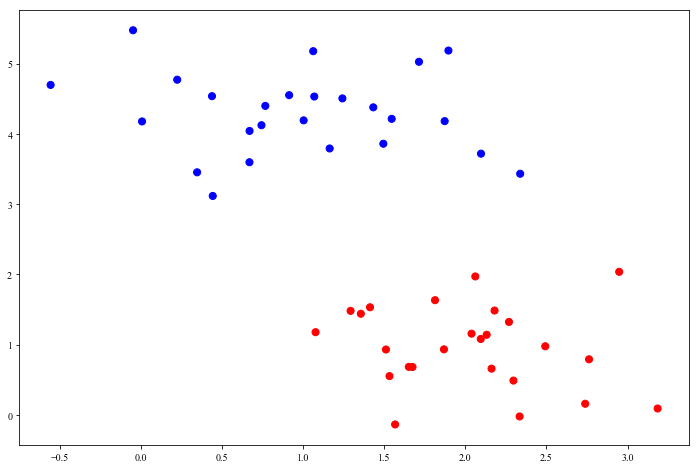

In [202]:
# Adapted from VanderPlas (2016) 
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
X, y = make_blobs(n_samples=50, centers=2,random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr');

A simple method to achieve this is to draw a separating line between the two data point classes. There are many algorithms that have been proposed to execute this task of seperating the data point classes with a seperation line known as a seperating hyperplane (Kirk, 2017). Generally, the methodology which is used to place this hyperplane is known as the maximum margin hyperplane which draws the hyperplane at the furthest distance from the edge data point classes which are termed the support vectors (James et al., 2013). This is shown below:

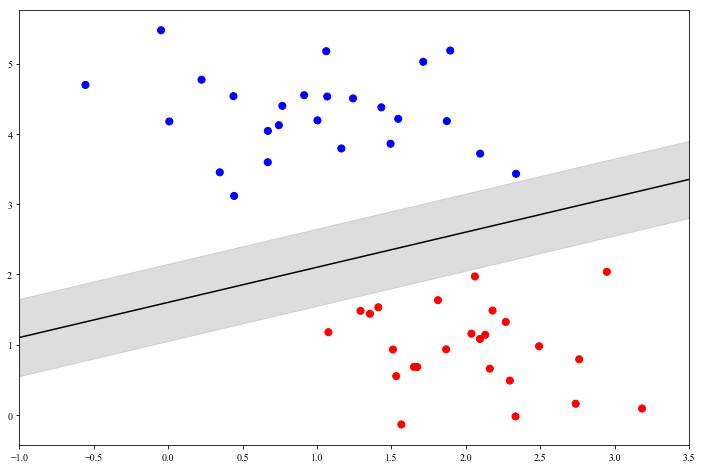

In [203]:
# Adapted from VanderPlas (2016) 
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
yfit = 0.5 * xfit + 1.6
plt.plot(xfit, yfit, '-k')
plt.fill_between(xfit, yfit - 0.55, yfit + 0.55, edgecolor='none',color='#AAAAAA', alpha=0.4)
plt.xlim(-1, 3.5);

This is task becomes problematic for many algorithms when the boundary between point classes become non-linear which is shown below:

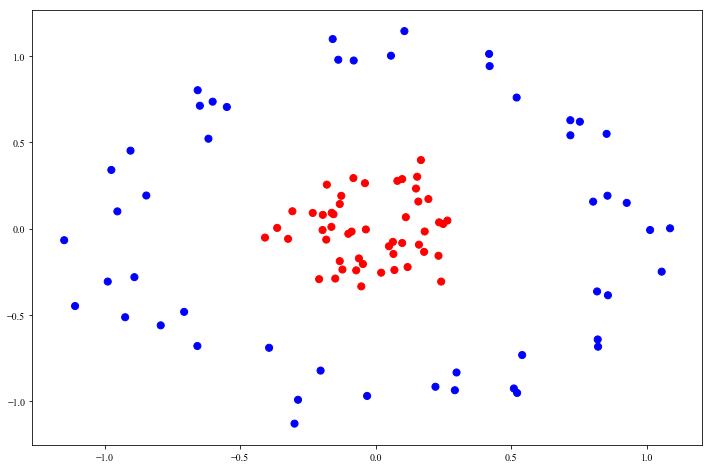

In [204]:
# Adapted from VanderPlas (2016) 
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
X, y = make_circles(100, factor=.2, noise=.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr');

This non-linear class boundary is where the SVM methodology differentiates itself from other algorithms, being able to draw a separating hyperplane of non-linear boundaries. SVMs are able to utilise the kernel trick which map the data into a higher dimensional feature space to accommodate non-linear bounadries. This conceptualised here with the same two-dimensional class boundary being mapped into three-dimensional feature space:

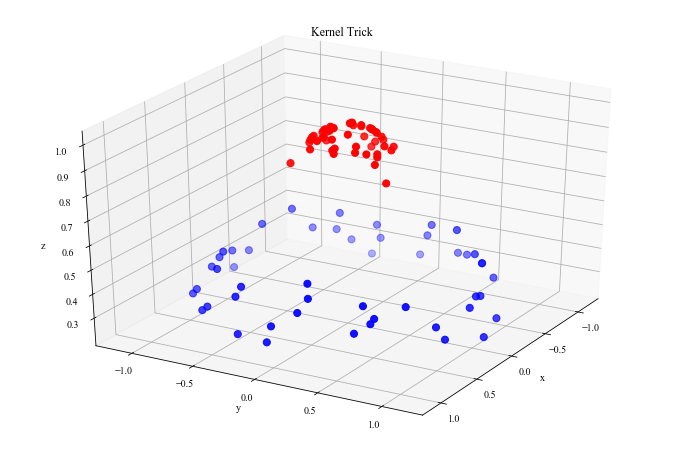

In [205]:
# Adapted from VanderPlas (2016) 
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
r = np.exp(-(X ** 2).sum(1))
ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='bwr')
ax.view_init(elev=30, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.set_title('Kernel Trick');

Once the feature space is mapped into a higher dimensional feature space, the SVM can now intersect the support vectors with the optimal sperarating hyperplane, converting the linear model to incoporate non-linear suppoer vector boundaries (Asif et al., 2014). The cost function (C) controls a tradeoff between the SVM models complexity of feature space enlargement and number of errors of misclassified data. Several methodologies have been proposed to set the optimal parameters of SVMs such as: (i) machine learning techniques such as genetic algorithms (see Cheng et al., 2017); (ii) bootstrapping (see Chatzimichali and Bessant, 2015); and, (iii) brute-force methodologies such as grid-search (see Dong et al., 2005). This study utilises the latter, grid-search, as it can achieve similar results to heuristic SVM parameter setting approaches when a smaller dimension of parameters is present (Jain et al., 2014). Grid-search was also used as it can be easily replicated for the RF methodology to enable a more similar comparison between both methodologies.

## 4.2 Random Forests
A decision tree is a data mining methodology for classifying a variable, in this study a decision tree would use the training variables and split the values of training variables to classify building types. Data is divided typically from the root node which splits into two child nodes based on the training variable which maximised the purity of its two child nosed (de Oña et al., 2015). This methodology may be suitable for classifying functional building uses as the decision tree formula is claimed to mirror real human decision-making processes (James et al., 2013).

Decision trees however are a limited methodology when applied to hetereogenous non-linear classification problems. This is because they sugger from high variance where a different criterion in splitting the training data can result in different prediction accuracies of the decision tree (James et al., 2013). Bagging is a proposed methodology to help allievate the problem of variance, it essentially calculates averaged prediction results of a decision tree  (Stevens et al., 2015).

Even with the use of bagging, the problem of variance still exists. A method to overomce this is instead to use and ensemble of decision trees, known as random forests, to increase performance accuracy  (Rasouli and Timmermans, 2014) this performace gain gives a slight trade-off of model intepretation (James et al., 2013). If an ensemble of highly correlated trees exist within the randomf forest, the problem of variance isn’t addressed. RFs can decorrelate its decision trees by stochastically removing a split candidate for each decision tree split. One strong predictive variable within the training data set can cause high correlation amongst trees, causing higher variance, as all the trees would use this for information gain By removing a split candidate it therefore decreases variance whilst increasing the robustness and accuracy of the model, this is how RFs differentiate themselves from bagged decision trees (Hageneur and Helbich, 2017; James et al., 2013; Stevens et al., 2015). 

Although random forests suffer from less interpretibility in comparison to decision trees, they have an advantage over SVMs which is a _black box methodology_. RF models, once trained, can output feature importance which measure the overall importance of each training variable in determining building usage. This metric is measured between 0 – 1 where a value towards one indicates higher importance of that variable for information gain in the RF model (Stevens et al., 2015). This enables further causal inference after the model has been trained.

## 4.3 Model Fitting
Both the SVM and RF is susceptible to the phenomenon of overfitting whereby models are overly tailored to the data they are trained upon (Xiao, 2017). k-fold cross validation is methodology to prevent this phenomenon. This randomly partitions the data into k folds which are generally of equal sizes where the first fold is taken as the validation fold the RF and SVM is then fitted to the remaining k – 1 folds (James et al., 2013). Grid-search can integrate k-fold cross validation into the parameter selection process, where the grid search process is fit to the training data and the best parameter results are taken as cross-validated average scores. This study used classification recall accuracy as the scoring mechanism for deciding both model’s hyperparameters – this, alongside F1 scores, were used as the overall model scoring metrics (see Results). These were choses as in this study demonstration there is not an cost of false positives or false negatives known a priori from the model outputs. The grid-search and k–fold cross-validation (k = 3) is shown here:
```python
svm_parameters = {'C':[1,0.25,0.5,0.75],'gamma': [1,2,3,'auto']}
svm_grid = GridSearchCV(svm, svm_parameters, verbose=3, cv=3, refit=True, n_jobs=-1)
svm_grid.fit(X_train, y_train)

rf_parameters = {'n_estimators':[10, 100], 'max_features':["auto", None, "sqrt", "log2"]
                 ,'min_samples_leaf':[1, 5], 'max_depth':[None, 5, 50], 'min_samples_split':[2, 5, 10]}
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_parameters, n_jobs=-1,verbose=3, cv=3, refit=True,verbose=3)
rf_grid.fit(X_train, y_train)

```

# 5. Results

In [330]:
# model_test = pd.DataFrame({'y_test':y_test,'svm_y_pred':svm_y_test_pred,'rf_y_pred':rf_y_test_pred})
# model_test.to_csv('DSSS_data/model_test.csv', index=False)
model_test = pd.read_csv('DSSS_data/model_test.csv')
print("\tRF:")
print(classification_report(model_test.y_test, model_test.rf_y_pred))
print("\n\tSVM:")
print(classification_report(model_test.y_test, model_test.svm_y_pred))

	RF:
              precision    recall  f1-score   support

  Commercial       0.92      0.94      0.93     43493
 Residential       0.99      0.99      0.99    332267

    accuracy                           0.98    375760
   macro avg       0.96      0.97      0.96    375760
weighted avg       0.98      0.98      0.98    375760


	SVM:
              precision    recall  f1-score   support

  Commercial       0.77      0.48      0.59     43493
 Residential       0.94      0.98      0.96    332267

    accuracy                           0.92    375760
   macro avg       0.85      0.73      0.78    375760
weighted avg       0.92      0.92      0.92    375760



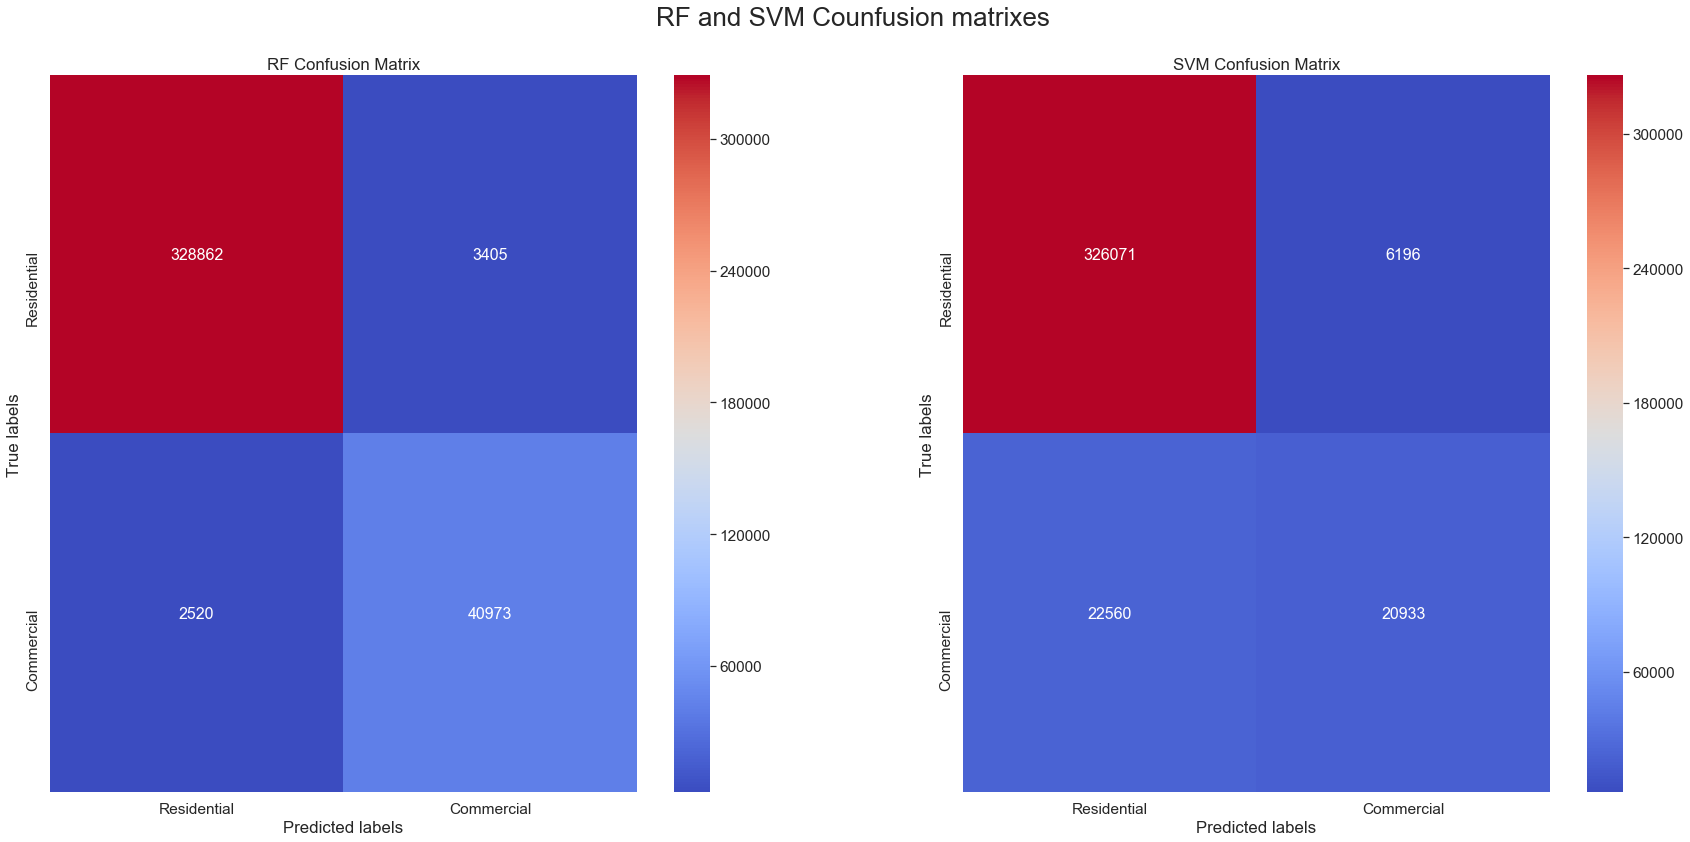

In [331]:
f, axes = plt.subplots(1, 2, figsize=(24.0, 12.0))
labels = ['Residential', 'Commercial']
rf_cf = pd.DataFrame(confusion_matrix(model_test.y_test, model_test.rf_y_pred, labels), range(2),range(2))
svm_cf = pd.DataFrame(confusion_matrix(model_test.y_test, model_test.svm_y_pred, labels), range(2),range(2))
sns.set(font_scale=1.4) #for label size

ax1 = sns.heatmap(rf_cf, annot=True,annot_kws={"size": 16}, fmt='g', ax=axes[0], cmap='coolwarm')# font size)
# ax1.set_xticklabels([''] + labels)
# ax1.set_yticklabels([''] + labels)
ax1.set_xlabel('Predicted labels');
ax1.set_ylabel('True labels'); 
ax1.set_title('RF Confusion Matrix'); 
ax1.xaxis.set_ticklabels(labels); 
ax1.yaxis.set_ticklabels(labels);

ax2 = sns.heatmap(svm_cf, annot=True,annot_kws={"size": 16}, fmt='g', ax=axes[1], cmap='coolwarm')# font size)
ax2.set_xlabel('Predicted labels');
ax2.set_ylabel('True labels'); 
ax2.set_title('SVM Confusion Matrix'); 
ax2.xaxis.set_ticklabels(labels); 
ax2.yaxis.set_ticklabels(labels);

plt.tight_layout(w_pad=8)
plt.subplots_adjust(top=0.90)
f.suptitle('RF and SVM Counfusion matrixes', size=26, verticalalignment='top');

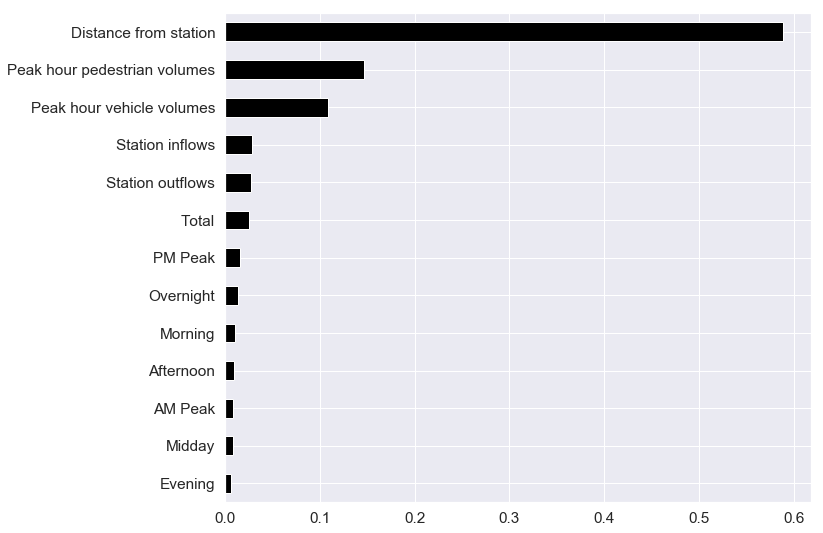

In [332]:
# FI scores saved manually due to lengthy fitting time
features = ['Evening', 'Midday', 'AM Peak', 'Afternoon', 'Morning', 'Overnight',
            'PM Peak', 'Total', 'Station outflows', 'Station inflows', 
            'Peak hour vehicle volumes', 'Peak hour pedestrian volumes', 'Distance from station'] # Feature Labels
fi_scores = [0.006996348917101767,0.008797350055235197, 0.00912021036845769,
             0.01000589629175361, 0.010326552935562568, 0.01393418187480259,
             0.01639262057131379, 0.025663455400875685, 0.02714954370143462, 
             0.028167756740236742, 0.10823560780861152, 0.14704553897276668, 0.5881649363618476]
feauture_importances = pd.Series(fi_scores, index=features)
feauture_importances.sort_values(inplace=True)
ax = feauture_importances.plot(kind="barh", figsize=(10.5,9), color='black');

# 6. Discussion

## 6.2 Application example


The automated prediction of functional land-use is important for the updating of city records which can quickly become out of date, the manual updating of this is both time and resource costly (Zhong _et al_., 2014;;).

Therefore, this study will now use an unseen newer dataset to demonstrate the models' application. Zhong _et al_. (2014) noted how surveyed land-use data, such as address directories, can quickly become outdated which can hinders the understanding of a city's functional zones - or it is costly to recalculate these usin city-wide surveys. Therefore, this study will use more up-to-date data from a seperate source to see if the model can correctly classify this unseen data correctly. This data provides information of newly registered apartment buildings within Toronto, these aren't geographically referenced like the extensive Toronto Address Point or Building outline datasets were. The dataset looks as follows:

In [9]:
apart = pd.read_csv("Data_EDA/apartments_geocoded.csv")
apart[apart.columns[0:-2]].head(4)

,_id,AIR_CONDITIONING_TYPE,AMENITIES_AVAILABLE,BALCONIES,BARRIER_FREE_ACCESSIBILTY_ENTR,BIKE_PARKING,EXTERIOR_FIRE_ESCAPE,FACILITIES_AVAILABLE?,FIRE_ALARM,GARBAGE_CHUTES,HEATING_TYPE,INTERCOM,IS_THERE_A_COOLING_ROOM?,IS_THERE_EMERGENCY_POWER?,LAUNDRY_ROOM,LOCKER_OR_STORAGE_ROOM,NO_BARRIERFREE_ACCESSBLE_UNITS,NO_OF_ACCESSIBLEPARKING_SPACES,NO_OF_ELEVATORS,NO_OF_STOREYS,NO_OF_UNITS,NON-SMOKING_BUILDING,PARKING_TYPE,PETS_ALLOWED,PROP_MANAGEMENT_COMPANY_NAME,PROPERTY_TYPE,RSN,SEPARATE_GAS_METERS_EACH_UNIT,SEPARATE_HYDRO_METER_EACH_UNIT,SEPARATE_WATER_METERS_EA_UNIT,SITE_ADDRESS,SPRINKLER_SYSTEM,VISITOR_PARKING,WARD,WINDOW_TYPE,YEAR_BUILT,YEAR_REGISTERED
0,6885,NONE,NaN,YES,NO,Not Available,NO,Green Bin / Organics,YES,NO,ELECTRIC,YES,NO,NO,YES,YES,0.0,0.0,1.0,6,13,NO,NaN,NO,GILINDO MARCOCCHIO LIMITED,PRIVATE,4356415,NO,NO,NO,173 Streetephen Drive Toronto,YES,UNAVAILABLE,03,DOUBLE PANE,1954.0,2018.0
1,6886,NONE,NaN,NO,NO,Not Available,YES,Unknown,YES,NO,HOT WATER,NO,NO,NO,NO,NO,NaN,0.0,0.0,3,16,YES,NaN,NO,NaN,PRIVATE,4379646,NO,YES,NO,1212 Bloor Street West Toronto,NO,UNAVAILABLE,09,DOUBLE PANE,1923.0,2018.0
2,6887,INDIVIDUAL UNITS,"Indoor pool , Sauna",NO,YES,98 indoor parking spots and 0 outdoor parking ...,NO,Recycling bins,YES,YES,ELECTRIC,YES,YES,YES,YES,NO,NaN,NaN,4.0,28,638,YES,"Underground Garage , Ground Level Garage , Gar...",YES,CRECCAL INVESTMENTS LTD,PRIVATE,4365726,NO,NO,NO,2360 Dundas Street West Toronto,YES,PAID,04,THERMAL,1976.0,2018.0
3,6888,CENTRAL AIR,"Indoor pool , Indoor recreation room , Indoor ...",YES,NO,Not Available,NO,Green Bin / Organics,YES,YES,HOT WATER,YES,NO,YES,YES,YES,0.0,0.0,2.0,13,128,YES,"Underground Garage , Garage accessible thru bu...",YES,PRINCESS MANAGEMENT,PRIVATE,4232592,NO,YES,NO,53 Westarrender Avenue Toronto,YES,FREE,02,SINGLE PANE,1971.0,2017.0


The generalisation and applicability of these models will be tested on this dataset, first this data needed to be _geocoded_ to geographically reference the apartment buildings locations for nearest-neighbour lookups of the different KSP sensor datasets. This then means the apartment data will have the same training variables as before, which can then be given to the RF and SVM models. This was achieved by connecting to an geocoding API to turn the address strings within the dataset into a point geometry with longitude and latitude. The address strings needed to be cleaned to be more readable for the API. Firstly, a function is defined that takes the address string and replaces the values of that string based on a dictionary - this is defined below and it replaces abbreviations in the string to be more understandable for the geocoding API e.g. `121 BLOOR ST W` into `121 Bloor Street West Toronto`:
``` python
def address_clean(add, dic):
    for k, i in dic.items():
        add = add.replace(k, i)
    if add[-1] == " ":
        add = add[0:-1]
    return add.title() + " Toronto"


replace_dict = {"  ":" ", " AVE":" Avenue", " RD":" Road",
                " ST":" Street", " BLVD":" Boulevard", " C": " Central",
                " E":" East", " W":" West", " DR":" Drive", 
                " crcl":" Circle", " crt":" Court", " pl":" Place", 
                " hts":" Heights", " ter":" Terrace", " pkwy":" Parkway"}

# Clean addresses with lambda func
apart["SITE_ADDRESS"] = apart.SITE_ADDRESS.apply(lambda x: address_clean(x, replace_dict)) 
```
There are many geocoding APIs available, this study used the Bing API to geocode addresses - this was chosen as it had a higher API limit than other APIs. Each geocoding API requires a different set of API call paramtres - this study used the `geopy` module which provided a standardised framework for geocoding address strings for many different API providers. This can be timely , so geocoded addresses were already included but the process of geocoding is as shown:


```python

from geopy.geocoders import Bing
# Specifiy Bing API key and the timeout wait time for API call
geolocatorBing = Bing(api_key= ????? , timeout=None)

count = 0 # Global var to count number of geocodes
latitudes, longitudes = [], [] # Lists to store lons ans lats
for add in apart.SITE_ADDRESS:
    try:
        geocode = geolocatorBing.geocode(add)
        latitudes.append(geocode.latitude) # Append lat
        longitudes.append(geocode.longitude) # Append lon
        if (len(latitudes) % 100) == 0: # Update every 100 records
            print('Geocoded {} addresses'.format(len(latitudes)))
    except:
        # Store None if geocode unsuccessful
        latitudes.append(None)
        latitudes.append(None) 
        if (len(latitudes) % 100) == 0: # Update every 100 records
            print('Geocoded {} addresses'.format(len(latitudes)))
```
Now the new apartment buildings are geocoded we can apply the same formatting to these points: aggregating points to building ploygons, calculating functional regions and classifying them from our model. 


```python

apart['geometry'] = [shapely.geometry.Point(lon,lat) for lon, lat in zip(apart.Longitude,apart.Latitude)]
apart = gpd.GeoDataFrame(apart)
apart.crs = {'init': 'epsg:4326'}
apart = apart.cx[xmin:xmax, ymin:ymax] # Bound to KSP study area

apart_nearest_points = [ckdnearest(apart, road_points,'RESULTID'),
ckdnearest(apart, station,'STATION'),
ckdnearest(apart, vehicle_ped_counts,'Sensor')] # Use kd-tree again for accelerated nn search

# Create the same X vars but now for new apartment buildings
apart_X = pd.concat([apart]+apart_nearest_points,axis=1) 
apart_X = apart_X.merge(vehicle_ped_counts, on='Sensor') # Complete the same merge operations
apart_X = apart_X.merge(station, on='STATION')
apart_X = apart_X.merge(road_points.drop(columns='geometry', axis=1), on='RESULTID')
apart_X = apart_X.loc[:,~apart_X.columns.duplicated()]

# Now predict buildings classes with RF and SVM
apart['SVM'] = pd.Series(svm.predict(apart_X))
apart['RF'] = pd.Series(rfc.predict(apart_X))

```

Classification report:

In [333]:
apart_y = ['Residential' for i in apart.RF]
print("\tRF:")
print(classification_report(apart_y, apart.RF))
print("\n\tSVM:")
print(classification_report(apart_y, apart.SVM))

	RF:
              precision    recall  f1-score   support

  Commercial       0.00      0.00      0.00         0
 Residential       1.00      0.94      0.97      3440

    accuracy                           0.94      3440
   macro avg       0.50      0.47      0.49      3440
weighted avg       1.00      0.94      0.97      3440


	SVM:
              precision    recall  f1-score   support

 Residential       1.00      1.00      1.00      3440

    accuracy                           1.00      3440
   macro avg       1.00      1.00      1.00      3440
weighted avg       1.00      1.00      1.00      3440



The RF confusion matrix is shown below:

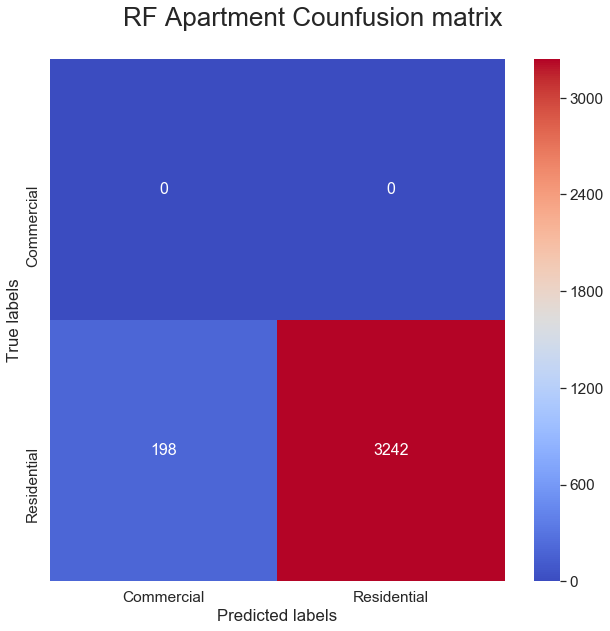

In [334]:
f, axes = plt.subplots(1, figsize=(9.0, 9.0))
labels = ['Residential', 'Commercial']
rf_cf = pd.DataFrame(confusion_matrix(apart_y, apart.RF), range(2),range(2))
svm_cf = pd.DataFrame(confusion_matrix(apart_y, apart.SVM), range(1),range(1))
sns.set(font_scale=1.4) #for label size

ax1 = sns.heatmap(rf_cf, annot=True,annot_kws={"size": 16}, fmt='g', ax=axes, cmap='coolwarm')# font size)
# ax1.set_xticklabels([''] + labels)
# ax1.set_yticklabels([''] + labels)
ax1.set_xlabel('Predicted labels');
ax1.set_ylabel('True labels'); 
ax1.xaxis.set_ticklabels(['Commercial', 'Residential']); 
ax1.yaxis.set_ticklabels(['Commercial', 'Residential']);

plt.tight_layout(w_pad=8)
plt.subplots_adjust(top=0.90)
f.suptitle('RF Apartment Counfusion matrix', size=26, verticalalignment='top');

## 6.3 Limitations and future research

Areas of large functional land-use overlaps are very typical and cause problems for predictive classification (Pan _et al_., 2013; Zhong _et al_., 2014; Lu _et al_., 2014). This can be more formerly measured through spatial autocorrelation. Local indicators of spatial association (LISA) can show areas of (dis)similar clusters based on local autocorrelation measures – these can be expressed as either: high-high (HH), high-low (HL), low-high (LH) or low-low (LL) values (Anselin, 1995). For example, LH refers to an observation with below average values with neighbouring values with above average. By transforming the residential and commercial classes into a Boolean value – the LISA autocorrelation values are shown below:

('WARNING: ', 126, ' is an island (no neighbors)')
('WARNING: ', 171, ' is an island (no neighbors)')
('WARNING: ', 172, ' is an island (no neighbors)')
('WARNING: ', 248, ' is an island (no neighbors)')
('WARNING: ', 270, ' is an island (no neighbors)')
('WARNING: ', 495, ' is an island (no neighbors)')
('WARNING: ', 510, ' is an island (no neighbors)')
('WARNING: ', 601, ' is an island (no neighbors)')
('WARNING: ', 647, ' is an island (no neighbors)')
('WARNING: ', 668, ' is an island (no neighbors)')
('WARNING: ', 671, ' is an island (no neighbors)')
('WARNING: ', 758, ' is an island (no neighbors)')
('WARNING: ', 870, ' is an island (no neighbors)')
('WARNING: ', 874, ' is an island (no neighbors)')
('WARNING: ', 1312, ' is an island (no neighbors)')
('WARNING: ', 1359, ' is an island (no neighbors)')
('WARNING: ', 1393, ' is an island (no neighbors)')
('WARNING: ', 1696, ' is an island (no neighbors)')
('WARNING: ', 1698, ' is an island (no neighbors)')
('WARNING: ', 1870, ' is a

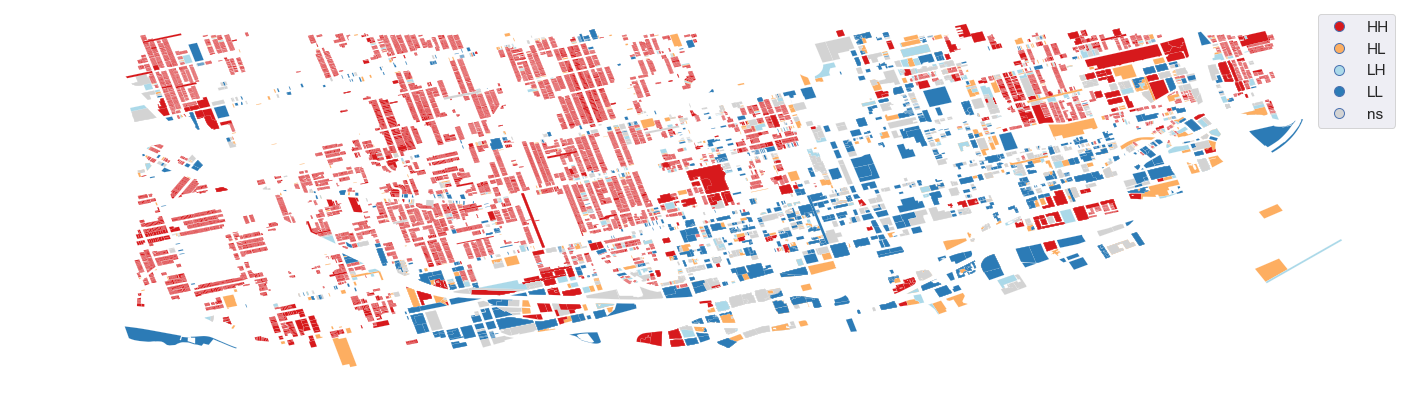

In [335]:
import warnings
warnings.filterwarnings('ignore') # Not usually advisable 
# but the next plot has lots of warnings due to spatial w matrix and noncontiguous buildings
f,ax = plt.subplots(1, figsize=(24.0, 12.0))
ksp_bt = gpd.read_file('DSSS_data/building_polys.geojson')
ksp_bt.CLASS = ksp_bt.CLASS.replace('Residential', 1).replace('Commercial', 0).astype(int)
moran_y = ksp_bt['CLASS'].values
w = ps.lib.weights.contiguity.Queen.from_dataframe(ksp_bt)
w.transform = 'r'
moran = ps.explore.esda.moran.Moran_Local(moran_y, w)
lisa_cluster(moran, ksp_bt, ax=ax); # Scroll down if island warnings appear

This supports the literature that many overlapping observations can be seen in the KSP study areas. There are some notable LISA clusters of dissimilar values surrounding the KSP, these are LH and HL clusters which show there are areas of commercial land-use surrounded by many residential buildings or areas of residential land-use surrounded by many commercial buildings. Spatial autocorrelation can be used as a method to measure the values of neighbouring observations which is an important influence for functional land-use (Zhong et al., 2014). This is a limitation of this study as it does not include in the training of the RF or SVM. 

This issue is not unique to this study and it ultimately requires further research. For example, _SpaceGAN_ is a proposal by Klemmer et al. (2019) to apply state-of-the-art deep learning for generative modelling of geospatial domains, this enables models to learn through spatial autocorrelation conditioning. As shown from the multiple LH and HL clusters above, there are empirical observations of commercial and residential buildings which are likely attributed the same training variables given their close spatial proximity within the nearest-neighbour search. This likely makes it difficult for the models to delineate between these building classes. The _SpaceGAN_ framework is able to extend this spatial representation beyond two-dimensional spatial coordinates, where each data point is conditioned on the values of itself and neighbouring values which enables the representation of spatial structures through local spatial autocorrelation (Klemmer et al., 2019). This form of spatial conditioning may be invaluable for improved functional land-use classification given most empirical observations would suggest high levels of overlapping between building classes can always be expected.  The benefits of spatial conditioning were demonstrated by _SpaceGAN_ which creates synthetic data which is faithful to the originally observed data by including a metric to limit the loss of spatial autocorrelation within the synthetic data creation, this data was then able to train an ensemble learning model (like RFs) to achieve a higher degree of accuracy (Klemmer et al., 2019).


# 7. Conclusion

# 8. References

Asif, M. T., Member, S., Dauwels, J., Member, S., Goh, C. Y., Oran, A., ... Jaillet, P. (2014). Spatiotemporal Patterns in Large-Scale Traffic Speed Prediction. _IEEE Transactions on Intelligent Transportation Systems_, 15(2), 794–804. 

Chatzimichali, E. and Bessant, C. (2015). Novel application of heuristic optimisation enables the creation and thorough evaluation of robust support vector machine ensembles for machine learning applications. _Metabolomics_, 12(1). pp.173-185 

Cheng, A., Jiang, X., Li, Y., Zhang, C. and Zhu, H. (2017). Multiple sources and multiple measures based traffic flow prediction using the chaos theory and support vector regression method. _Physica A: Statistical Mechanics and its Applications 466_, pp.422-434 

De Ona, J., de Oña, R., Eboli, L. and Mazzulla, G. (2015). Heterogeneity in perceptions of service quality among groups of railway passengers. _International Journal of Sustainable Transportation_, 9(8), pp.612-626.
Dong, B., Cao, C. and Lee, S. (2005). Applying support vector machines to predict building energy consumption in tropical region. _Energy and Buildings_, 37(5), pp.545-553. 

Hagenauer, J. and Helbich, M. (2017). A comparative study of machine learning classifiers for modeling travel mode choice. _Expert Systems with Applications_, 78, pp.273-282.

Hu, S. and Wang, L. (2012). Automated urban land-use classification with remote sensing. _International Journal of Remote Sensing_, 34(3), pp.790-803.

James, G., Witten, D., Hastie, T. and Tibshirani, R. (2013). An introduction to statistical learning. London: _Springer_, 102, pp.303-368. 

Kirk, M. (2017). Thoughtful machine learning with Python. 1st ed. London: 9781491924136, pp. 243-256. 

Klemmer, K., Koshiyama, A. and Flennerhag, S. (2019). Augmenting correlation structures in spatial data using deep generative models. _arXiv preprint arXiv:1905.09796_.

Lu, Z., Im, J., Rhee, J. and Hodgson, M. (2014). Building type classification using spatial and landscape attributes derived from LiDAR remote sensing data. _Landscape and Urban Planning_, 130, pp.134-148.

Meng, X., Currit, N., Wang, L. and Yang, X. (2012). Detect Residential Buildings from Lidar and Aerial Photographs through Object-Oriented Land-Use Classification. _Photogrammetric Engineering & Remote Sensing_, 78(1), pp.35-44.

Pan, G., Qi, G., Wu, Z., Zhang, D. and Li, S. (2013). Land-Use Classification Using Taxi GPS Traces. _IEEE Transactions on Intelligent Transportation Systems_, 14(1), pp.113-123.

Stevens, F.R., Gaughan, A.E., Linard, C. and Tatem, A.J. (2015). Disaggregating census data for population mapping using random forests with remotely-sensed and ancillary data. _PloS one_, 10(2), p.e0107042.

Zhong, C., Huang, X., Müller Arisona, S., Schmitt, G. and Batty, M. (2014). Inferring building functions from a probabilistic model using public transportation data. _Computers, Environment and Urban Systems_, 48, pp.124-137.
